该代码适用于10个风险资产，且是此论文实验中用到的代码：https://arxiv.org/abs/2412.18563

This code is applicable for 10 risky assets and was implemented in the empirical analysis of this paper: https://arxiv.org/abs/2412.18563

In [1]:
import logging
# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
import time
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
# plotting
%matplotlib notebook
%matplotlib inline

/home/andy/miniconda3/envs/sblines3/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
start = time.time()

In [4]:
# 生成随机种子
seed1 = np.random.randint(0, 2**31 - 1)
seed2 = np.random.randint(0, 2**31 - 1)
seed3 = np.random.randint(0, 2**31 - 1)
seed4 = np.random.randint(0, 2**31 - 1)
seed5 = np.random.randint(0, 2**31 - 1)

# seed1=334244355
# seed2=1639950351
# seed3=1790997128
# seed4=1971071600
# seed5=734789405


# 设置随机种子
np.random.seed(seed1)
random.seed(seed2)
torch.manual_seed(seed3)
torch.cuda.manual_seed(seed4)
torch.cuda.manual_seed_all(seed5)

# 保存这些种子值以便之后打印
seeds_dict = {
    'numpy_seed': seed1,
    'random_seed': seed2,
    'torch_seed': seed3,
    'cuda_seed': seed4,
    'cuda_all_seed': seed5
}

In [5]:
# params
window_length = 50
steps = 128

In [6]:
# # save dir
# save_dir = "./outputs/pytorch-DDPG/"
# os.makedirs(save_dir, exist_ok=True)

# Environment Definition

In [7]:
# from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.callbacks.notebook_plot import LivePlotNotebook
from rl_portfolio_management.config import eps

In [8]:
from rl_portfolio_management.util import sharpe

class DataSrc(object):
    """Acts as data provider for each new episode."""

    def __init__(self, 
                 df,
                 steps=252, 
                 scale=True, scale_extra_cols=True, augment=0.00, window_length=50, random_reset=True):
        """
        DataSrc.

        df - csv for data frame index of timestamps
             and multi-index columns levels=[['LTCBTC'],...],['open','low','high','close',...]]
             an example is included as an hdf file in this repository
        steps - total steps in episode
        scale - scale the data for each episode
        scale_extra_cols - scale extra columns by global mean and std
        augment - fraction to augment the data by
        random_reset - reset to a random time (otherwise continue through time)
        """
        self.steps = steps + 1
        self.augment = augment
        self.random_reset = random_reset
        self.scale = scale
        self.scale_extra_cols = scale_extra_cols
        self.window_length = window_length
        self.idx = self.window_length
        


        # get rid of NaN's
        df = df.copy()
        df.replace(np.nan, 0, inplace=True)
        df = df.fillna(method="pad")

        # dataframe to matrix
        self.asset_names = df.columns.levels[0].tolist()
        self.features = df.columns.levels[1].tolist()
        data = df.values.reshape(
            (len(df), len(self.asset_names), len(self.features)))
        self._data = np.transpose(data, (1, 0, 2))
        self._times = df.index

        self.price_columns = ['close', 'high', 'low']
#         self.price_columns = ['close', 'high', 'low', 'open']
        self.non_price_columns = set(
            df.columns.levels[1]) - set(self.price_columns)

        # Stats to let us normalize non price columns
        if scale_extra_cols:
            x = self._data.reshape((-1, len(self.features)))
            self.stats = dict(mean=x.mean(0), std=x.std(0))
            # for column in self._data.columns.levels[1].tolist():
            #     x = df.xs(key=column, axis=1, level='Price').as_matrix()[:, :]
            #     self.stats["mean"].append(x.mean())
            #      = dict(mean=x.mean(), std=x.std())

        self.reset()

    def _step(self):
        # get history matrix from dataframe
        data_window = self.data[:, self.step:self.step +
                                self.window_length].copy()
        # (eq.1) prices
        y1 = data_window[:, -1, 0] / data_window[:, -2, 0]
        y1 = np.concatenate([[1.0], y1])  # add cash price

        # (eq 18) X: prices are divided by close price
        nb_pc = len(self.price_columns)
        if self.scale:
            last_close_price = data_window[:, -1, 0]
            data_window[:, :, :nb_pc] /= last_close_price[:,
                                                          np.newaxis, np.newaxis]

        if self.scale_extra_cols:
            # normalize non price columns
            data_window[:, :, nb_pc:] -= self.stats["mean"][None, None, nb_pc:]
            data_window[:, :, nb_pc:] /= self.stats["std"][None, None, nb_pc:]
            data_window[:, :, nb_pc:] = np.clip(
                data_window[:, :, nb_pc:],
                self.stats["mean"][nb_pc:] - self.stats["std"][nb_pc:] * 10,
                self.stats["mean"][nb_pc:] + self.stats["std"][nb_pc:] * 10
            )
            data_window[np.isinf(data_window)] = 0
            data_window[np.isnan(data_window)] = 0

        self.step += 1
        history = data_window
        done = bool(self.step >= self.steps)

        return history, y1, done

    def reset(self):
        self.step = 0

        # get data for this episode
        if self.random_reset:
            self.idx = np.random.randint(
                low=self.window_length + 1, high=self._data.shape[1] - self.steps - 2)
        else:
            # 总是从数据集的起始位置开始（该功能主要用在测试集中）
            self.idx = self.window_length + 1

#             # continue sequentially, before reseting to start
#             if self.idx>(self._data.shape[1] - self.steps - self.window_length - 1):
#                 self.idx=self.window_length + 1
#             else:
#                 self.idx += self.steps
                
        data = self._data[:, self.idx -
                          self.window_length:self.idx + self.steps + 1].copy()
        self.times = self._times[self.idx -
                                 self.window_length:self.idx + self.steps + 1]

        # augment data to prevent overfitting
        data += np.random.normal(loc=0, scale=self.augment, size=data.shape)

        self.data = data


class PortfolioSim(object):
    """
    Portfolio management sim.

    Params:
    - cost e.g. 0.0025 is max in Poliniex

    Based of [Jiang 2017](https://arxiv.org/abs/1706.10059)
    """

    def __init__(self, asset_names=[], steps=128, trading_cost=0.0025, time_cost=0.0):
        self.cost = trading_cost
        self.time_cost = time_cost
        self.steps = steps
        self.asset_names = asset_names
        self.reset()

    def _step(self, w1, y1):
        """
        Step.

        w1 - new action of portfolio weights - e.g. [0.1,0.9, 0.0]
        y1 - price relative vector also called return
            e.g. [1.0, 0.9, 1.1]
        Numbered equations are from https://arxiv.org/abs/1706.10059
        """
        w0 = self.w0
        p0 = self.p0
        #
        # print("y1:",y1)
        # print("w1",w1)
        dw1 = (y1 * w0) / (np.dot(y1, w0) + eps)  # (eq7) weights evolve into
        # print("w0:",w0)
        # (eq16) cost to change portfolio
        # (excluding change in cash to avoid double counting for transaction cost)
        c1 = self.cost * (
            np.abs(dw1[1:] - w1[1:])).sum()

        p1 = p0 * (1 - c1) * np.exp(np.dot(np.log(y1), w0))  # (eq11) final portfolio value

        p1 = p1 * (1 - self.time_cost)  # we can add a cost to holding

        # can't have negative holdings in this model (no shorts)
        # p1 = np.clip(p1, 0, np.inf)

        rho1 = p1 / p0 - 1  # rate of returns
        r1 = np.log((p1 + eps) / (p0 + eps))  # (eq10) log rate of return
        # r1 = np.log(1 - c1) + np.dot(np.log(y1), w0)  # (eq10) log rate of return
        # (eq22) immediate reward is log rate of return scaled by episode length

        self.ret.append(r1) # 把收益率保存在容器中

        reward = sharpe(np.array(self.ret)) / self.steps
        # reward = r1 / self.steps
        # reward = np.power(r1, 1/self.steps)

        # remember for next step
        self.w0 = w1
        self.p0 = p1


        # if we run out of money, we're done
        done = bool(p1 == 0)

        # should only return single values, not list
        info = {
            "reward": reward,
            "log_return": r1,
            "portfolio_value": p1,
            "market_return": y1.mean(),
            "rate_of_return": rho1,
            "weights_mean": w1.mean(),
            "weights_std": w1.std(),
            "cost": c1,
        }
        # record weights and prices
        for i, name in enumerate(['CASH'] + self.asset_names):
            info['weight_' + name] = w1[i]
            info['price_' + name] = y1[i]

        self.infos.append(info)
        return reward, info, done

    def reset(self):
        self.infos = []
        self.w0 = np.array([1.0] + [0.0] * len(self.asset_names))
        self.p0 = 1.0
        self.ret = [] # 定义一个容器，保存收益率，用作sharpe比率计算


class PortfolioEnv(gym.Env):
    """
    An environment for financial portfolio management.

    Financial portfolio management is the process of constant redistribution of a fund into different
    financial products.

    Based on [Huang 2020](https://arxiv.org/abs/2012.13773)
    """
    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {'render.modes': ['notebook', 'ansi']}

    
    def __init__(self,
                 df,
                 steps=256,
                 trading_cost=0.0025,
                 time_cost=0.00,
                 window_length=window_length,
                 augment=0.00,
                 output_mode='DRLOPT',
                 log_dir=None,
                 scale=True,
                 scale_extra_cols=True,
                 random_reset=True
                 ):
        """
        An environment for financial portfolio management.

        Params:
            df - csv for data frame index of timestamps
                 and multi-index columns levels=[['LTCBTC'],...],['open','low','high','close']]
            steps - steps in episode
            window_length - how many past observations["history"] to return
            trading_cost - cost of trade as a fraction,  e.g. 0.0025 corresponding to max rate of 0.25% at Poloniex (2017)
            time_cost - cost of holding as a fraction
            augment - fraction to randomly shift data by
            output_mode: decides observation["history"] shape
            - 'DRLOPT' for (assets, window, 3)
            - 'atari' for (window, window, 3) (assets is padded)
            - 'mlp' for (assets*window*3)
            log_dir: directory to save plots to
            scale - scales price data by last opening price on each episode (except return)
            scale_extra_cols - scales non price data using mean and std for whole dataset
        """
        super(PortfolioEnv, self).__init__()
        self.src = DataSrc(df=df, steps=steps, scale=scale, scale_extra_cols=scale_extra_cols,
                           augment=augment, window_length=window_length,
                           random_reset=random_reset)  # 使用实际的random_reset值
        self._plot = self._plot2 = self._plot3 = None
        self.output_mode = output_mode
        self.sim = PortfolioSim(
            asset_names=self.src.asset_names,
            trading_cost=trading_cost,
            time_cost=time_cost,
            steps=steps)
        self.log_dir = log_dir

        # openai gym attributes
        # action will be the portfolio weights [cash_bias,w1,w2...] where wn are [-1, 1] for each asset
        nb_assets = len(self.src.asset_names)
        self.action_space = gym.spaces.Box(0, 1.0, shape=(nb_assets + 1,), dtype=np.float32)
        
        # get the history space from the data min and max
        if output_mode == 'DRLOPT':
            obs_shape = (
                nb_assets,
                window_length,
                len(self.src.features)
            )
            
        self.observation_space = gym.spaces.Dict({
            'history': gym.spaces.Box(
                -10,
                20 if scale else 1,  # if scale=True observed price changes return could be large fractions
                obs_shape
            ),
            'weights': self.action_space    
        })
        
    def reset(self):
        self.sim.reset()
        self.src.reset()
        self.infos = []
        action = self.sim.w0
        observation, reward, done, info = self.step(action)
        return observation
    
    def step(self, action):
        """
        Step the env.

        Actions should be portfolio [w0...]
        - Where wn is a portfolio weight between 0 and 1. The first (w0) is cash_bias
        - cn is the portfolio conversion weights see PortioSim._step for description
        """
        logger.debug('action: %s', action)
#         weights = np.clip(action, -1.0, 1.0)
#         weights[0] = np.clip(weights[0], 0, 1)
#         weights_abs = np.abs(weights)
#         weights /= weights_abs.sum() + eps
        # print('weights:',weights)
        # weights = action
        weights = action
        
#         weights /= weights.sum() 


        # Sanity checks
        assert self.action_space.contains(
            action), 'action should be within %r but is %r' % (self.action_space, action)
        np.testing.assert_almost_equal(
            np.sum(weights), 1.0, 3, err_msg='weights should sum to 1. action="%s"' % weights)

        history, y1, done1 = self.src._step()

        reward, info, done2 = self.sim._step(weights, y1)

        # calculate return for buy and hold a bit of each asset
        info['market_value'] = np.cumprod(
            [inf["market_return"] for inf in self.infos + [info]])[-1]
        # add dates
        info['date'] = self.src.times[self.src.step].timestamp()
        info['steps'] = self.src.step

        self.infos.append(info)

        # reshape history according to output mode
        if self.output_mode == 'DRLOPT':
            pass
        elif self.output_mode == 'atari':
            padding = history.shape[1] - history.shape[0]
            history = np.pad(history, [[0, padding], [
                0, 0], [0, 0]], mode='constant')
        elif self.output_mode == 'mlp':
            history = history.flatten()

        return {'history': history, 'weights': weights}, reward, done1 or done2, info
    
    def _seed(self, seed):
        np.random.seed(seed)
        return [seed]

    def render(self, mode='notebook', close=False):
        # if close:
            # return
        if mode == 'ansi':
            pprint(self.infos[-1])
        elif mode == 'notebook':
            self.plot_notebook(close)

    def plot_notebook(self, close=False):
        """Live plot using the jupyter notebook rendering of matplotlib."""

        if close:
            self._plot = self._plot2 = self._plot3 = None
            return

        df_info = pd.DataFrame(self.infos)
        df_info.index = pd.to_datetime(df_info["date"], unit='s')

        # plot prices and performance
        all_assets = ['CASH'] + self.sim.asset_names
        if not self._plot:
            colors = [None] * len(all_assets) + ['black']
            self._plot_dir = os.path.join(
                self.log_dir, 'notebook_plot_prices_' + str(time.time())) if self.log_dir else None
            self._plot = LivePlotNotebook(
                log_dir=self._plot_dir, title='prices & performance', labels=all_assets + ["Portfolio"], ylabel='value', colors=colors)
        x = df_info.index
        y_portfolio = df_info["portfolio_value"]
        y_assets = [df_info['price_' + name].cumprod()
                    for name in all_assets]
        self._plot.update(x, y_assets + [y_portfolio])


        # plot portfolio weights
        if not self._plot2:
            self._plot_dir2 = os.path.join(
                self.log_dir, 'notebook_plot_weights_' + str(time.time())) if self.log_dir else None
            self._plot2 = LivePlotNotebook(
                log_dir=self._plot_dir2, labels=all_assets, title='weights', ylabel='weight')
        ys = [df_info['weight_' + name] for name in all_assets]
        self._plot2.update(x, ys)

        # plot portfolio costs
        if not self._plot3:
            self._plot_dir3 = os.path.join(
                self.log_dir, 'notebook_plot_cost_' + str(time.time())) if self.log_dir else None
            self._plot3 = LivePlotNotebook(
                log_dir=self._plot_dir3, labels=['cost'], title='costs', ylabel='cost')
        ys = [df_info['cost']]
        self._plot3.update(x, ys)

        if close:
            self._plot = self._plot2 = self._plot3 = None


# APPLY ENV

In [9]:
from rl_portfolio_management.util import MDD, sharpe, softmax, MDD1, sortino, calmar, other_metrics
from rl_portfolio_management.wrappers import SoftmaxActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/chinaStock_1d_vol.hf',key='train')
df_test = pd.read_hdf('./data/chinaStock_1d_vol.hf',key='test')

In [10]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
#         reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [11]:
env = PortfolioEnv(df=df_train, steps=steps, output_mode='DRLOPT')

In [12]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='DRLOPT', random_reset=True)
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test(df=df_test, steps=steps):
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='DRLOPT', random_reset=False)
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((4, 51, 10), (4, 51, 10))

In [13]:
# task.observation_space

In [14]:
# Instantiate the env
env = task_fn()

In [15]:
# env_test = task_fn_test()

try:
    env_test = task_fn_test()
except  ValueError:
    print("回测区间数据量不够，请增加回测数据")
    assert False, "程序执行终止"

In [16]:
# env_test.observation_space

In [17]:
# from stable_baselines3.common.env_checker import check_env
# check_env(env)

/home/andy/miniconda3/envs/sblines3/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:27: UserWarning: It seems that your observation  is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  f"It seems that your observation {key} is an image but the `dtype` "
/home/andy/miniconda3/envs/sblines3/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:35: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  f"It seems that your observation space {key} is an image but the "
/home/andy/miniconda3/envs/sblines3/lib/python3.7/site-packages/stable_baselines3/common/env_checker.py:48: UserWarning: The minimal resolution for an image is 36x36 for the default

In [18]:
# check_env(env_test)

In [19]:
print(task.reset().shape[0])
# num_act = task.reset().shape[2] 
env.action_space.shape[-1] - 1

4


10

In [20]:
import gym
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# from rl_portfolio_management.customExtractor import CustomCNN
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, 
                 observation_space: gym.spaces.Box, 
                 features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper       
        n_input_channels = observation_space.shape[0]
#         num_act = observation_space.shape[2]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim, bias=True), nn.ReLU(), nn.Dropout(p=0.1))

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

In [21]:
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.policies import BaseModel, BasePolicy, register_policy

# from stable_baselines3.common.policies import BaseModel, BasePolicy, create_sde_features_extractor, register_policy
# from stable_baselines3.td3.policies import Actor, TD3Policy
# from stable_baselines3.common.preprocessing import get_action_dim

In [22]:
# class CustomNetwork(nn.Module):
#     """
#     Custom network for policy and value function.
#     It receives as input the features extracted by the feature extractor.

#     :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
#     :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
#     :param last_layer_dim_vf: (int) number of units for the last layer of the value network
#     """

#     def __init__(
#         self,
#         feature_dim: int,
#         last_layer_dim_pi: int = 64,
#         last_layer_dim_vf: int = 64,
#     ):
#         super(CustomNetwork, self).__init__()
        
#         # IMPORTANT:
#         # Save output dimensions, used to create the distributions
#         self.latent_dim_pi = last_layer_dim_pi
#         self.latent_dim_vf = last_layer_dim_vf
#         dropout_half = nn.Dropout(p=0.5)

#         # Policy network
#         self.policy_net = nn.Sequential(
#             nn.Linear(feature_dim, 256), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(256, 128), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(128, last_layer_dim_pi), 
#         )
#         # Value network
#         self.value_net = nn.Sequential(
#             nn.Linear(feature_dim, 128), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(128, 64), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(64, last_layer_dim_vf), 
#         )

#     def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
#         """
#         :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
#             If all layers are shared, then ``latent_policy == latent_value``
#         """
#         return self.policy_net(features), self.value_net(features)


# class CustomActorCriticPolicy(ActorCriticPolicy):
#     def __init__(
#         self,
#         observation_space: gym.spaces.Space,
#         action_space: gym.spaces.Space,
#         lr_schedule: Callable[[float], float],
#         net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
#         activation_fn: Type[nn.Module] = nn.Tanh,
#         *args,
#         **kwargs,
#     ):

#         super(CustomActorCriticPolicy, self).__init__(
#             observation_space,
#             action_space,
#             lr_schedule,
#             net_arch,
#             activation_fn,
#             # Pass remaining arguments to base class
#             *args,
#             **kwargs,
#         )
#         # Disable orthogonal initialization
#         self.ortho_init = False

#     def _build_mlp_extractor(self) -> None:
#         self.mlp_extractor = CustomNetwork(self.features_dim,
#                                            last_layer_dim_pi = env.action_space.shape[-1],
#                                            last_layer_dim_vf = 1,
#                                           )
        

In [23]:
from stable_baselines3 import PPO
# from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# The noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.3 * np.ones(n_actions))
# lr_schedule = [[4e-5],5e-4]

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=1024),
    net_arch=[dict(pi=[128,128],vf=[128,128])],
)

In [24]:
model = PPO('MlpPolicy', env, policy_kwargs=policy_kwargs,
            tensorboard_log="./runs/ppo-vgg1-softmax",
            batch_size=256,
#             learning_rate=5e-4,
            verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [25]:
# model = TD3(CustomTD3Policy, env, policy_kwargs=policy_kwargs, verbose=1)

In [26]:
model.learn(9000000) 

Logging to ./runs/ppo-vgg1-softmax/PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | -0.351   |
| time/              |          |
|    fps             | 423      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.784       |
| time/                   |              |
|    fps                  | 454          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0066342624 |
|    clip_fraction        | 0.0589       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.6        |
|    explained_va

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.876      |
| time/                   |             |
|    fps                  | 508         |
|    iterations           | 11          |
|    time_elapsed         | 44          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.041386135 |
|    clip_fraction        | 0.356       |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.5       |
|    explained_variance   | 0.655       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0738     |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0482     |
|    std                  | 0.987       |
|    value_loss           | 0.0364      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.68      |
| time/                   |            |
|    fps                  | 519        |
|    iterations           | 21         |
|    time_elapsed         | 82         |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 0.10720711 |
|    clip_fraction        | 0.521      |
|    clip_range           | 0.2        |
|    entropy_loss         | -15.3      |
|    explained_variance   | 0.406      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0763    |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0555    |
|    std                  | 0.973      |
|    value_loss           | 0.0243     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.15      |
| time/                   |            |
|    fps                  | 522        |
|    iterations           | 31         |
|    time_elapsed         | 121        |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.25445125 |
|    clip_fraction        | 0.68       |
|    clip_range           | 0.2        |
|    entropy_loss         | -15.1      |
|    explained_variance   | 0.472      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.117     |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0827    |
|    std                  | 0.955      |
|    value_loss           | 0.0295     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -1.07     |
| time/                   |           |
|    fps                  | 525       |
|    iterations           | 41        |
|    time_elapsed         | 159       |
|    total_timesteps      | 83968     |
| train/                  |           |
|    approx_kl            | 0.3433516 |
|    clip_fraction        | 0.705     |
|    clip_range           | 0.2       |
|    entropy_loss         | -14.8     |
|    explained_variance   | 0.657     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.123    |
|    n_updates            | 400       |
|    policy_gradient_loss | -0.0827   |
|    std                  | 0.931     |
|    value_loss           | 0.0261    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -1.19     |
| time/                   |           |
|    fps                  | 526       |
|    iterations           | 51        |
|    time_elapsed         | 198       |
|    total_timesteps      | 104448    |
| train/                  |           |
|    approx_kl            | 0.4354225 |
|    clip_fraction        | 0.74      |
|    clip_range           | 0.2       |
|    entropy_loss         | -14.6     |
|    explained_variance   | 0.668     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.109    |
|    n_updates            | 500       |
|    policy_gradient_loss | -0.0864   |
|    std                  | 0.909     |
|    value_loss           | 0.0438    |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.18      |
| time/                   |            |
|    fps                  | 527        |
|    iterations           | 61         |
|    time_elapsed         | 236        |
|    total_timesteps      | 124928     |
| train/                  |            |
|    approx_kl            | 0.44237083 |
|    clip_fraction        | 0.74       |
|    clip_range           | 0.2        |
|    entropy_loss         | -14.4      |
|    explained_variance   | 0.626      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.11      |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.0731    |
|    std                  | 0.892      |
|    value_loss           | 0.0403     |
----------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean    

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.842    |
| time/                   |           |
|    fps                  | 528       |
|    iterations           | 71        |
|    time_elapsed         | 275       |
|    total_timesteps      | 145408    |
| train/                  |           |
|    approx_kl            | 0.6127689 |
|    clip_fraction        | 0.769     |
|    clip_range           | 0.2       |
|    entropy_loss         | -14.2     |
|    explained_variance   | 0.578     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.109    |
|    n_updates            | 700       |
|    policy_gradient_loss | -0.0794   |
|    std                  | 0.878     |
|    value_loss           | 0.0407    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.839    |
| time/                   |           |
|    fps                  | 528       |
|    iterations           | 81        |
|    time_elapsed         | 313       |
|    total_timesteps      | 165888    |
| train/                  |           |
|    approx_kl            | 0.6594525 |
|    clip_fraction        | 0.774     |
|    clip_range           | 0.2       |
|    entropy_loss         | -14       |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0937   |
|    n_updates            | 800       |
|    policy_gradient_loss | -0.0688   |
|    std                  | 0.863     |
|    value_loss           | 0.0227    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.754     |
| time/                   |            |
|    fps                  | 528        |
|    iterations           | 91         |
|    time_elapsed         | 352        |
|    total_timesteps      | 186368     |
| train/                  |            |
|    approx_kl            | 0.69381905 |
|    clip_fraction        | 0.76       |
|    clip_range           | 0.2        |
|    entropy_loss         | -13.8      |
|    explained_variance   | 0.696      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.101     |
|    n_updates            | 900        |
|    policy_gradient_loss | -0.0736    |
|    std                  | 0.844      |
|    value_loss           | 0.0253     |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.899    |
| time/                   |           |
|    fps                  | 528       |
|    iterations           | 101       |
|    time_elapsed         | 391       |
|    total_timesteps      | 206848    |
| train/                  |           |
|    approx_kl            | 0.7784128 |
|    clip_fraction        | 0.789     |
|    clip_range           | 0.2       |
|    entropy_loss         | -13.6     |
|    explained_variance   | 0.534     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0969   |
|    n_updates            | 1000      |
|    policy_gradient_loss | -0.0709   |
|    std                  | 0.83      |
|    value_loss           | 0.0318    |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128       

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.909    |
| time/                   |           |
|    fps                  | 529       |
|    iterations           | 111       |
|    time_elapsed         | 429       |
|    total_timesteps      | 227328    |
| train/                  |           |
|    approx_kl            | 0.8661567 |
|    clip_fraction        | 0.783     |
|    clip_range           | 0.2       |
|    entropy_loss         | -13.4     |
|    explained_variance   | 0.714     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0884   |
|    n_updates            | 1100      |
|    policy_gradient_loss | -0.072    |
|    std                  | 0.816     |
|    value_loss           | 0.0285    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.722    |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 121       |
|    time_elapsed         | 467       |
|    total_timesteps      | 247808    |
| train/                  |           |
|    approx_kl            | 0.9454179 |
|    clip_fraction        | 0.797     |
|    clip_range           | 0.2       |
|    entropy_loss         | -13.1     |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.106    |
|    n_updates            | 1200      |
|    policy_gradient_loss | -0.0735   |
|    std                  | 0.796     |
|    value_loss           | 0.0263    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.759    |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 131       |
|    time_elapsed         | 505       |
|    total_timesteps      | 268288    |
| train/                  |           |
|    approx_kl            | 0.8253223 |
|    clip_fraction        | 0.793     |
|    clip_range           | 0.2       |
|    entropy_loss         | -12.9     |
|    explained_variance   | 0.658     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0797   |
|    n_updates            | 1300      |
|    policy_gradient_loss | -0.0558   |
|    std                  | 0.784     |
|    value_loss           | 0.0442    |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128       

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.515    |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 141       |
|    time_elapsed         | 544       |
|    total_timesteps      | 288768    |
| train/                  |           |
|    approx_kl            | 1.0300145 |
|    clip_fraction        | 0.801     |
|    clip_range           | 0.2       |
|    entropy_loss         | -12.7     |
|    explained_variance   | 0.726     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.116    |
|    n_updates            | 1400      |
|    policy_gradient_loss | -0.0744   |
|    std                  | 0.765     |
|    value_loss           | 0.0308    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0156    |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 151       |
|    time_elapsed         | 583       |
|    total_timesteps      | 309248    |
| train/                  |           |
|    approx_kl            | 1.0697001 |
|    clip_fraction        | 0.803     |
|    clip_range           | 0.2       |
|    entropy_loss         | -12.4     |
|    explained_variance   | 0.777     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.105    |
|    n_updates            | 1500      |
|    policy_gradient_loss | -0.0625   |
|    std                  | 0.75      |
|    value_loss           | 0.0363    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.394    |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 161       |
|    time_elapsed         | 621       |
|    total_timesteps      | 329728    |
| train/                  |           |
|    approx_kl            | 1.3940129 |
|    clip_fraction        | 0.81      |
|    clip_range           | 0.2       |
|    entropy_loss         | -12.3     |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.102    |
|    n_updates            | 1600      |
|    policy_gradient_loss | -0.0616   |
|    std                  | 0.741     |
|    value_loss           | 0.0309    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.452   |
| time/                   |          |
|    fps                  | 530      |
|    iterations           | 171      |
|    time_elapsed         | 659      |
|    total_timesteps      | 350208   |
| train/                  |          |
|    approx_kl            | 1.118385 |
|    clip_fraction        | 0.808    |
|    clip_range           | 0.2      |
|    entropy_loss         | -12.1    |
|    explained_variance   | 0.857    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.103   |
|    n_updates            | 1700     |
|    policy_gradient_loss | -0.0577  |
|    std                  | 0.726    |
|    value_loss           | 0.0325   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.23     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 181       |
|    time_elapsed         | 697       |
|    total_timesteps      | 370688    |
| train/                  |           |
|    approx_kl            | 1.2492651 |
|    clip_fraction        | 0.815     |
|    clip_range           | 0.2       |
|    entropy_loss         | -11.9     |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0927   |
|    n_updates            | 1800      |
|    policy_gradient_loss | -0.0637   |
|    std                  | 0.712     |
|    value_loss           | 0.0493    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.292   |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 191      |
|    time_elapsed         | 735      |
|    total_timesteps      | 391168   |
| train/                  |          |
|    approx_kl            | 1.233998 |
|    clip_fraction        | 0.806    |
|    clip_range           | 0.2      |
|    entropy_loss         | -11.7    |
|    explained_variance   | 0.824    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.115   |
|    n_updates            | 1900     |
|    policy_gradient_loss | -0.0646  |
|    std                  | 0.7      |
|    value_loss           | 0.0292   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.177   |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 201      |
|    time_elapsed         | 774      |
|    total_timesteps      | 411648   |
| train/                  |          |
|    approx_kl            | 1.248764 |
|    clip_fraction        | 0.813    |
|    clip_range           | 0.2      |
|    entropy_loss         | -11.5    |
|    explained_variance   | 0.816    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.114   |
|    n_updates            | 2000     |
|    policy_gradient_loss | -0.0678  |
|    std                  | 0.689    |
|    value_loss           | 0.0445   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.471    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 211       |
|    time_elapsed         | 813       |
|    total_timesteps      | 432128    |
| train/                  |           |
|    approx_kl            | 1.3859619 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | -11.3     |
|    explained_variance   | 0.748     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0926   |
|    n_updates            | 2100      |
|    policy_gradient_loss | -0.0538   |
|    std                  | 0.679     |
|    value_loss           | 0.0391    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0972    |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 221       |
|    time_elapsed         | 852       |
|    total_timesteps      | 452608    |
| train/                  |           |
|    approx_kl            | 1.3062305 |
|    clip_fraction        | 0.815     |
|    clip_range           | 0.2       |
|    entropy_loss         | -11.1     |
|    explained_variance   | 0.793     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.104    |
|    n_updates            | 2200      |
|    policy_gradient_loss | -0.0672   |
|    std                  | 0.662     |
|    value_loss           | 0.0429    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.187   |
| time/                   |          |
|    fps                  | 530      |
|    iterations           | 231      |
|    time_elapsed         | 891      |
|    total_timesteps      | 473088   |
| train/                  |          |
|    approx_kl            | 1.616431 |
|    clip_fraction        | 0.826    |
|    clip_range           | 0.2      |
|    entropy_loss         | -10.9    |
|    explained_variance   | 0.787    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.101   |
|    n_updates            | 2300     |
|    policy_gradient_loss | -0.0601  |
|    std                  | 0.652    |
|    value_loss           | 0.0402   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.703    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 241       |
|    time_elapsed         | 929       |
|    total_timesteps      | 493568    |
| train/                  |           |
|    approx_kl            | 1.5348489 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | -10.7     |
|    explained_variance   | 0.72      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0867   |
|    n_updates            | 2400      |
|    policy_gradient_loss | -0.0548   |
|    std                  | 0.642     |
|    value_loss           | 0.0323    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.417   |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 251      |
|    time_elapsed         | 967      |
|    total_timesteps      | 514048   |
| train/                  |          |
|    approx_kl            | 1.389682 |
|    clip_fraction        | 0.818    |
|    clip_range           | 0.2      |
|    entropy_loss         | -10.6    |
|    explained_variance   | 0.823    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.12    |
|    n_updates            | 2500     |
|    policy_gradient_loss | -0.0566  |
|    std                  | 0.634    |
|    value_loss           | 0.0282   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.371    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 261       |
|    time_elapsed         | 1005      |
|    total_timesteps      | 534528    |
| train/                  |           |
|    approx_kl            | 1.3199693 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | -10.4     |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0909   |
|    n_updates            | 2600      |
|    policy_gradient_loss | -0.0591   |
|    std                  | 0.622     |
|    value_loss           | 0.0261    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.713    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 271       |
|    time_elapsed         | 1044      |
|    total_timesteps      | 555008    |
| train/                  |           |
|    approx_kl            | 1.5614672 |
|    clip_fraction        | 0.823     |
|    clip_range           | 0.2       |
|    entropy_loss         | -10.2     |
|    explained_variance   | 0.794     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0917   |
|    n_updates            | 2700      |
|    policy_gradient_loss | -0.0664   |
|    std                  | 0.611     |
|    value_loss           | 0.0377    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.288    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 281       |
|    time_elapsed         | 1082      |
|    total_timesteps      | 575488    |
| train/                  |           |
|    approx_kl            | 1.3537488 |
|    clip_fraction        | 0.83      |
|    clip_range           | 0.2       |
|    entropy_loss         | -10.1     |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0958   |
|    n_updates            | 2800      |
|    policy_gradient_loss | -0.0585   |
|    std                  | 0.607     |
|    value_loss           | 0.0425    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.368    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 291       |
|    time_elapsed         | 1120      |
|    total_timesteps      | 595968    |
| train/                  |           |
|    approx_kl            | 1.5943989 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | -10       |
|    explained_variance   | 0.744     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0741   |
|    n_updates            | 2900      |
|    policy_gradient_loss | -0.0519   |
|    std                  | 0.601     |
|    value_loss           | 0.0366    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.283    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 301       |
|    time_elapsed         | 1158      |
|    total_timesteps      | 616448    |
| train/                  |           |
|    approx_kl            | 1.6169754 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.9      |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0788   |
|    n_updates            | 3000      |
|    policy_gradient_loss | -0.0361   |
|    std                  | 0.596     |
|    value_loss           | 0.0484    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.16      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 311       |
|    time_elapsed         | 1197      |
|    total_timesteps      | 636928    |
| train/                  |           |
|    approx_kl            | 1.6354631 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.76     |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.101    |
|    n_updates            | 3100      |
|    policy_gradient_loss | -0.0499   |
|    std                  | 0.587     |
|    value_loss           | 0.036     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.239    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 321       |
|    time_elapsed         | 1235      |
|    total_timesteps      | 657408    |
| train/                  |           |
|    approx_kl            | 1.8420138 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.57     |
|    explained_variance   | 0.736     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.079    |
|    n_updates            | 3200      |
|    policy_gradient_loss | -0.0338   |
|    std                  | 0.579     |
|    value_loss           | 0.0287    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.192    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 331       |
|    time_elapsed         | 1272      |
|    total_timesteps      | 677888    |
| train/                  |           |
|    approx_kl            | 1.9301972 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.45     |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0942   |
|    n_updates            | 3300      |
|    policy_gradient_loss | -0.0568   |
|    std                  | 0.572     |
|    value_loss           | 0.0254    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.257    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 341       |
|    time_elapsed         | 1310      |
|    total_timesteps      | 698368    |
| train/                  |           |
|    approx_kl            | 2.0325785 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.3      |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0709   |
|    n_updates            | 3400      |
|    policy_gradient_loss | -0.0292   |
|    std                  | 0.564     |
|    value_loss           | 0.0344    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0604   |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 351       |
|    time_elapsed         | 1348      |
|    total_timesteps      | 718848    |
| train/                  |           |
|    approx_kl            | 1.7021198 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.13     |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0921   |
|    n_updates            | 3500      |
|    policy_gradient_loss | -0.0481   |
|    std                  | 0.556     |
|    value_loss           | 0.0337    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.303    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 361       |
|    time_elapsed         | 1386      |
|    total_timesteps      | 739328    |
| train/                  |           |
|    approx_kl            | 1.9197164 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | -9.07     |
|    explained_variance   | 0.787     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0568   |
|    n_updates            | 3600      |
|    policy_gradient_loss | -0.0322   |
|    std                  | 0.553     |
|    value_loss           | 0.041     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.229    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 371       |
|    time_elapsed         | 1424      |
|    total_timesteps      | 759808    |
| train/                  |           |
|    approx_kl            | 2.1181128 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.91     |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0955   |
|    n_updates            | 3700      |
|    policy_gradient_loss | -0.0529   |
|    std                  | 0.545     |
|    value_loss           | 0.055     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.106    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 381       |
|    time_elapsed         | 1462      |
|    total_timesteps      | 780288    |
| train/                  |           |
|    approx_kl            | 2.0432181 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.78     |
|    explained_variance   | 0.788     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.081    |
|    n_updates            | 3800      |
|    policy_gradient_loss | -0.0481   |
|    std                  | 0.539     |
|    value_loss           | 0.0271    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.189    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 391       |
|    time_elapsed         | 1501      |
|    total_timesteps      | 800768    |
| train/                  |           |
|    approx_kl            | 2.1662183 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.69     |
|    explained_variance   | 0.657     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0894   |
|    n_updates            | 3900      |
|    policy_gradient_loss | -0.0444   |
|    std                  | 0.535     |
|    value_loss           | 0.0424    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.157    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 401       |
|    time_elapsed         | 1541      |
|    total_timesteps      | 821248    |
| train/                  |           |
|    approx_kl            | 2.0072484 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.57     |
|    explained_variance   | 0.708     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0967   |
|    n_updates            | 4000      |
|    policy_gradient_loss | -0.0433   |
|    std                  | 0.528     |
|    value_loss           | 0.0267    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.107   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 411      |
|    time_elapsed         | 1580     |
|    total_timesteps      | 841728   |
| train/                  |          |
|    approx_kl            | 2.029125 |
|    clip_fraction        | 0.856    |
|    clip_range           | 0.2      |
|    entropy_loss         | -8.43    |
|    explained_variance   | 0.861    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0764  |
|    n_updates            | 4100     |
|    policy_gradient_loss | -0.0424  |
|    std                  | 0.522    |
|    value_loss           | 0.0326   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.3      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 421       |
|    time_elapsed         | 1618      |
|    total_timesteps      | 862208    |
| train/                  |           |
|    approx_kl            | 2.1213436 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.28     |
|    explained_variance   | 0.709     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0852   |
|    n_updates            | 4200      |
|    policy_gradient_loss | -0.0424   |
|    std                  | 0.515     |
|    value_loss           | 0.039     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.157    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 431       |
|    time_elapsed         | 1657      |
|    total_timesteps      | 882688    |
| train/                  |           |
|    approx_kl            | 1.7385471 |
|    clip_fraction        | 0.849     |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.11     |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0421   |
|    n_updates            | 4300      |
|    policy_gradient_loss | -0.0265   |
|    std                  | 0.507     |
|    value_loss           | 0.0474    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.242   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 441      |
|    time_elapsed         | 1696     |
|    total_timesteps      | 903168   |
| train/                  |          |
|    approx_kl            | 2.549797 |
|    clip_fraction        | 0.84     |
|    clip_range           | 0.2      |
|    entropy_loss         | -8.01    |
|    explained_variance   | 0.808    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0781  |
|    n_updates            | 4400     |
|    policy_gradient_loss | -0.0393  |
|    std                  | 0.503    |
|    value_loss           | 0.0448   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.175     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 451       |
|    time_elapsed         | 1735      |
|    total_timesteps      | 923648    |
| train/                  |           |
|    approx_kl            | 2.0819647 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.81     |
|    explained_variance   | 0.794     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0737   |
|    n_updates            | 4500      |
|    policy_gradient_loss | -0.042    |
|    std                  | 0.494     |
|    value_loss           | 0.0385    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.0776  |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 461      |
|    time_elapsed         | 1774     |
|    total_timesteps      | 944128   |
| train/                  |          |
|    approx_kl            | 1.951299 |
|    clip_fraction        | 0.855    |
|    clip_range           | 0.2      |
|    entropy_loss         | -7.72    |
|    explained_variance   | 0.841    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0755  |
|    n_updates            | 4600     |
|    policy_gradient_loss | -0.0346  |
|    std                  | 0.49     |
|    value_loss           | 0.0261   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.326   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 471      |
|    time_elapsed         | 1812     |
|    total_timesteps      | 964608   |
| train/                  |          |
|    approx_kl            | 2.314018 |
|    clip_fraction        | 0.849    |
|    clip_range           | 0.2      |
|    entropy_loss         | -7.6     |
|    explained_variance   | 0.812    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0885  |
|    n_updates            | 4700     |
|    policy_gradient_loss | -0.0505  |
|    std                  | 0.485    |
|    value_loss           | 0.0422   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0116   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 481       |
|    time_elapsed         | 1850      |
|    total_timesteps      | 985088    |
| train/                  |           |
|    approx_kl            | 2.2782838 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.43     |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0951   |
|    n_updates            | 4800      |
|    policy_gradient_loss | -0.0259   |
|    std                  | 0.478     |
|    value_loss           | 0.0277    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.00837  |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 491      |
|    time_elapsed         | 1889     |
|    total_timesteps      | 1005568  |
| train/                  |          |
|    approx_kl            | 2.309744 |
|    clip_fraction        | 0.849    |
|    clip_range           | 0.2      |
|    entropy_loss         | -7.31    |
|    explained_variance   | 0.749    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0816  |
|    n_updates            | 4900     |
|    policy_gradient_loss | -0.0393  |
|    std                  | 0.472    |
|    value_loss           | 0.0277   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.177    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 501      |
|    time_elapsed         | 1927     |
|    total_timesteps      | 1026048  |
| train/                  |          |
|    approx_kl            | 2.247991 |
|    clip_fraction        | 0.846    |
|    clip_range           | 0.2      |
|    entropy_loss         | -7.2     |
|    explained_variance   | 0.851    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0982  |
|    n_updates            | 5000     |
|    policy_gradient_loss | -0.0442  |
|    std                  | 0.467    |
|    value_loss           | 0.0388   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0614   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 511       |
|    time_elapsed         | 1966      |
|    total_timesteps      | 1046528   |
| train/                  |           |
|    approx_kl            | 3.2899258 |
|    clip_fraction        | 0.854     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.1      |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0964   |
|    n_updates            | 5100      |
|    policy_gradient_loss | -0.0418   |
|    std                  | 0.463     |
|    value_loss           | 0.0267    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0603    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 521       |
|    time_elapsed         | 2004      |
|    total_timesteps      | 1067008   |
| train/                  |           |
|    approx_kl            | 3.2904227 |
|    clip_fraction        | 0.857     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.99     |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0794   |
|    n_updates            | 5200      |
|    policy_gradient_loss | -0.0402   |
|    std                  | 0.458     |
|    value_loss           | 0.0404    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.133    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 531      |
|    time_elapsed         | 2042     |
|    total_timesteps      | 1087488  |
| train/                  |          |
|    approx_kl            | 2.469322 |
|    clip_fraction        | 0.854    |
|    clip_range           | 0.2      |
|    entropy_loss         | -6.83    |
|    explained_variance   | 0.738    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0669  |
|    n_updates            | 5300     |
|    policy_gradient_loss | -0.0436  |
|    std                  | 0.451    |
|    value_loss           | 0.0524   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0101   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 541       |
|    time_elapsed         | 2081      |
|    total_timesteps      | 1107968   |
| train/                  |           |
|    approx_kl            | 2.0235877 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.72     |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0943   |
|    n_updates            | 5400      |
|    policy_gradient_loss | -0.0494   |
|    std                  | 0.447     |
|    value_loss           | 0.0408    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.111    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 551       |
|    time_elapsed         | 2120      |
|    total_timesteps      | 1128448   |
| train/                  |           |
|    approx_kl            | 1.9665322 |
|    clip_fraction        | 0.851     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.61     |
|    explained_variance   | 0.767     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0735   |
|    n_updates            | 5500      |
|    policy_gradient_loss | -0.0378   |
|    std                  | 0.442     |
|    value_loss           | 0.0409    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.481    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 561      |
|    time_elapsed         | 2160     |
|    total_timesteps      | 1148928  |
| train/                  |          |
|    approx_kl            | 2.153351 |
|    clip_fraction        | 0.856    |
|    clip_range           | 0.2      |
|    entropy_loss         | -6.53    |
|    explained_variance   | 0.828    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0871  |
|    n_updates            | 5600     |
|    policy_gradient_loss | -0.0418  |
|    std                  | 0.439    |
|    value_loss           | 0.0431   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.157    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 571       |
|    time_elapsed         | 2199      |
|    total_timesteps      | 1169408   |
| train/                  |           |
|    approx_kl            | 1.9996388 |
|    clip_fraction        | 0.851     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.48     |
|    explained_variance   | 0.794     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0748   |
|    n_updates            | 5700      |
|    policy_gradient_loss | -0.0293   |
|    std                  | 0.437     |
|    value_loss           | 0.0455    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.508     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 581       |
|    time_elapsed         | 2238      |
|    total_timesteps      | 1189888   |
| train/                  |           |
|    approx_kl            | 2.0830655 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.36     |
|    explained_variance   | 0.759     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0896   |
|    n_updates            | 5800      |
|    policy_gradient_loss | -0.0551   |
|    std                  | 0.432     |
|    value_loss           | 0.0367    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.154    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 591      |
|    time_elapsed         | 2277     |
|    total_timesteps      | 1210368  |
| train/                  |          |
|    approx_kl            | 2.00433  |
|    clip_fraction        | 0.849    |
|    clip_range           | 0.2      |
|    entropy_loss         | -6.27    |
|    explained_variance   | 0.67     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0721  |
|    n_updates            | 5900     |
|    policy_gradient_loss | -0.0351  |
|    std                  | 0.429    |
|    value_loss           | 0.0484   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.13      |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 601       |
|    time_elapsed         | 2316      |
|    total_timesteps      | 1230848   |
| train/                  |           |
|    approx_kl            | 3.5278702 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.19     |
|    explained_variance   | 0.668     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.102    |
|    n_updates            | 6000      |
|    policy_gradient_loss | -0.0471   |
|    std                  | 0.426     |
|    value_loss           | 0.0463    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0281   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 611       |
|    time_elapsed         | 2355      |
|    total_timesteps      | 1251328   |
| train/                  |           |
|    approx_kl            | 2.4675708 |
|    clip_fraction        | 0.854     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.05     |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0948   |
|    n_updates            | 6100      |
|    policy_gradient_loss | -0.0365   |
|    std                  | 0.421     |
|    value_loss           | 0.0344    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.427    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 621      |
|    time_elapsed         | 2394     |
|    total_timesteps      | 1271808  |
| train/                  |          |
|    approx_kl            | 2.069673 |
|    clip_fraction        | 0.842    |
|    clip_range           | 0.2      |
|    entropy_loss         | -5.94    |
|    explained_variance   | 0.788    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.083   |
|    n_updates            | 6200     |
|    policy_gradient_loss | -0.0313  |
|    std                  | 0.417    |
|    value_loss           | 0.0391   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.279    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 631      |
|    time_elapsed         | 2432     |
|    total_timesteps      | 1292288  |
| train/                  |          |
|    approx_kl            | 2.561817 |
|    clip_fraction        | 0.849    |
|    clip_range           | 0.2      |
|    entropy_loss         | -5.87    |
|    explained_variance   | 0.752    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0642  |
|    n_updates            | 6300     |
|    policy_gradient_loss | -0.0338  |
|    std                  | 0.414    |
|    value_loss           | 0.0511   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.416     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 641       |
|    time_elapsed         | 2470      |
|    total_timesteps      | 1312768   |
| train/                  |           |
|    approx_kl            | 3.0693767 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.61     |
|    explained_variance   | 0.779     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0616   |
|    n_updates            | 6400      |
|    policy_gradient_loss | -0.0439   |
|    std                  | 0.404     |
|    value_loss           | 0.0553    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0333   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 651       |
|    time_elapsed         | 2509      |
|    total_timesteps      | 1333248   |
| train/                  |           |
|    approx_kl            | 3.5022373 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.54     |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0824   |
|    n_updates            | 6500      |
|    policy_gradient_loss | -0.0312   |
|    std                  | 0.403     |
|    value_loss           | 0.0441    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0454    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 661       |
|    time_elapsed         | 2547      |
|    total_timesteps      | 1353728   |
| train/                  |           |
|    approx_kl            | 2.1491308 |
|    clip_fraction        | 0.852     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.5      |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.065    |
|    n_updates            | 6600      |
|    policy_gradient_loss | -0.0397   |
|    std                  | 0.401     |
|    value_loss           | 0.0536    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.244     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 671       |
|    time_elapsed         | 2585      |
|    total_timesteps      | 1374208   |
| train/                  |           |
|    approx_kl            | 2.2173905 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.37     |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0918   |
|    n_updates            | 6700      |
|    policy_gradient_loss | -0.0382   |
|    std                  | 0.396     |
|    value_loss           | 0.0317    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.00144  |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 681       |
|    time_elapsed         | 2624      |
|    total_timesteps      | 1394688   |
| train/                  |           |
|    approx_kl            | 2.0075755 |
|    clip_fraction        | 0.852     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.3      |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0972   |
|    n_updates            | 6800      |
|    policy_gradient_loss | -0.0322   |
|    std                  | 0.393     |
|    value_loss           | 0.0403    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.159    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 691       |
|    time_elapsed         | 2662      |
|    total_timesteps      | 1415168   |
| train/                  |           |
|    approx_kl            | 2.1770284 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.19     |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0976   |
|    n_updates            | 6900      |
|    policy_gradient_loss | -0.0411   |
|    std                  | 0.389     |
|    value_loss           | 0.033     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.147     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 701       |
|    time_elapsed         | 2701      |
|    total_timesteps      | 1435648   |
| train/                  |           |
|    approx_kl            | 2.5346675 |
|    clip_fraction        | 0.849     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.18     |
|    explained_variance   | 0.817     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0608   |
|    n_updates            | 7000      |
|    policy_gradient_loss | -0.0329   |
|    std                  | 0.389     |
|    value_loss           | 0.0317    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.259     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 711       |
|    time_elapsed         | 2738      |
|    total_timesteps      | 1456128   |
| train/                  |           |
|    approx_kl            | 2.0600219 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.08     |
|    explained_variance   | 0.66      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.093    |
|    n_updates            | 7100      |
|    policy_gradient_loss | -0.0347   |
|    std                  | 0.385     |
|    value_loss           | 0.0301    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.119    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 721      |
|    time_elapsed         | 2776     |
|    total_timesteps      | 1476608  |
| train/                  |          |
|    approx_kl            | 2.214431 |
|    clip_fraction        | 0.853    |
|    clip_range           | 0.2      |
|    entropy_loss         | -4.91    |
|    explained_variance   | 0.716    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.118   |
|    n_updates            | 7200     |
|    policy_gradient_loss | -0.0405  |
|    std                  | 0.38     |
|    value_loss           | 0.0368   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.281     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 731       |
|    time_elapsed         | 2815      |
|    total_timesteps      | 1497088   |
| train/                  |           |
|    approx_kl            | 2.2053878 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.8      |
|    explained_variance   | 0.66      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.079    |
|    n_updates            | 7300      |
|    policy_gradient_loss | -0.0361   |
|    std                  | 0.376     |
|    value_loss           | 0.0398    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.174    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 741       |
|    time_elapsed         | 2853      |
|    total_timesteps      | 1517568   |
| train/                  |           |
|    approx_kl            | 2.0054197 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.65     |
|    explained_variance   | 0.838     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0882   |
|    n_updates            | 7400      |
|    policy_gradient_loss | -0.0284   |
|    std                  | 0.371     |
|    value_loss           | 0.026     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0193   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 751       |
|    time_elapsed         | 2891      |
|    total_timesteps      | 1538048   |
| train/                  |           |
|    approx_kl            | 2.1840534 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.62     |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0885   |
|    n_updates            | 7500      |
|    policy_gradient_loss | -0.0332   |
|    std                  | 0.37      |
|    value_loss           | 0.0419    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0327   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 761       |
|    time_elapsed         | 2929      |
|    total_timesteps      | 1558528   |
| train/                  |           |
|    approx_kl            | 2.0285058 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.52     |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.103    |
|    n_updates            | 7600      |
|    policy_gradient_loss | -0.0409   |
|    std                  | 0.367     |
|    value_loss           | 0.028     |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.357     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 771       |
|    time_elapsed         | 2968      |
|    total_timesteps      | 1579008   |
| train/                  |           |
|    approx_kl            | 1.8551111 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.46     |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0915   |
|    n_updates            | 7700      |
|    policy_gradient_loss | -0.0396   |
|    std                  | 0.364     |
|    value_loss           | 0.0308    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.348    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 781      |
|    time_elapsed         | 3006     |
|    total_timesteps      | 1599488  |
| train/                  |          |
|    approx_kl            | 2.31992  |
|    clip_fraction        | 0.849    |
|    clip_range           | 0.2      |
|    entropy_loss         | -4.34    |
|    explained_variance   | 0.805    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0751  |
|    n_updates            | 7800     |
|    policy_gradient_loss | -0.0336  |
|    std                  | 0.361    |
|    value_loss           | 0.0337   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.397     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 791       |
|    time_elapsed         | 3044      |
|    total_timesteps      | 1619968   |
| train/                  |           |
|    approx_kl            | 1.7520349 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.22     |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0692   |
|    n_updates            | 7900      |
|    policy_gradient_loss | -0.033    |
|    std                  | 0.356     |
|    value_loss           | 0.0336    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.056    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 801       |
|    time_elapsed         | 3083      |
|    total_timesteps      | 1640448   |
| train/                  |           |
|    approx_kl            | 2.4802828 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.12     |
|    explained_variance   | 0.633     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0607   |
|    n_updates            | 8000      |
|    policy_gradient_loss | -0.0317   |
|    std                  | 0.353     |
|    value_loss           | 0.0446    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.204    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 811       |
|    time_elapsed         | 3121      |
|    total_timesteps      | 1660928   |
| train/                  |           |
|    approx_kl            | 2.3741732 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.98     |
|    explained_variance   | 0.586     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0472   |
|    n_updates            | 8100      |
|    policy_gradient_loss | -0.0269   |
|    std                  | 0.349     |
|    value_loss           | 0.0473    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0872    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 821       |
|    time_elapsed         | 3160      |
|    total_timesteps      | 1681408   |
| train/                  |           |
|    approx_kl            | 1.9738724 |
|    clip_fraction        | 0.851     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.94     |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0915   |
|    n_updates            | 8200      |
|    policy_gradient_loss | -0.0409   |
|    std                  | 0.347     |
|    value_loss           | 0.0427    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.18     |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 831      |
|    time_elapsed         | 3199     |
|    total_timesteps      | 1701888  |
| train/                  |          |
|    approx_kl            | 1.988309 |
|    clip_fraction        | 0.845    |
|    clip_range           | 0.2      |
|    entropy_loss         | -3.86    |
|    explained_variance   | 0.8      |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0541  |
|    n_updates            | 8300     |
|    policy_gradient_loss | -0.0319  |
|    std                  | 0.345    |
|    value_loss           | 0.0467   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.23      |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 841       |
|    time_elapsed         | 3238      |
|    total_timesteps      | 1722368   |
| train/                  |           |
|    approx_kl            | 1.7890325 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.74     |
|    explained_variance   | 0.71      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0909   |
|    n_updates            | 8400      |
|    policy_gradient_loss | -0.0165   |
|    std                  | 0.341     |
|    value_loss           | 0.0344    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.124     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 851       |
|    time_elapsed         | 3277      |
|    total_timesteps      | 1742848   |
| train/                  |           |
|    approx_kl            | 1.9570806 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.69     |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0968   |
|    n_updates            | 8500      |
|    policy_gradient_loss | -0.0369   |
|    std                  | 0.339     |
|    value_loss           | 0.0254    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.597     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 861       |
|    time_elapsed         | 3315      |
|    total_timesteps      | 1763328   |
| train/                  |           |
|    approx_kl            | 2.2997136 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.55     |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0854   |
|    n_updates            | 8600      |
|    policy_gradient_loss | -0.0346   |
|    std                  | 0.336     |
|    value_loss           | 0.0339    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0928    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 871       |
|    time_elapsed         | 3354      |
|    total_timesteps      | 1783808   |
| train/                  |           |
|    approx_kl            | 4.0524135 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.46     |
|    explained_variance   | 0.775     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0916   |
|    n_updates            | 8700      |
|    policy_gradient_loss | -0.0438   |
|    std                  | 0.333     |
|    value_loss           | 0.033     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.787     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 881       |
|    time_elapsed         | 3393      |
|    total_timesteps      | 1804288   |
| train/                  |           |
|    approx_kl            | 1.9483912 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.29     |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0758   |
|    n_updates            | 8800      |
|    policy_gradient_loss | -0.0301   |
|    std                  | 0.328     |
|    value_loss           | 0.0486    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.275     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 891       |
|    time_elapsed         | 3432      |
|    total_timesteps      | 1824768   |
| train/                  |           |
|    approx_kl            | 1.9135667 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.22     |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0677   |
|    n_updates            | 8900      |
|    policy_gradient_loss | -0.0445   |
|    std                  | 0.326     |
|    value_loss           | 0.0421    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0136    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 901       |
|    time_elapsed         | 3470      |
|    total_timesteps      | 1845248   |
| train/                  |           |
|    approx_kl            | 2.0768735 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.06     |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0895   |
|    n_updates            | 9000      |
|    policy_gradient_loss | -0.0403   |
|    std                  | 0.321     |
|    value_loss           | 0.0279    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.269   |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 911      |
|    time_elapsed         | 3509     |
|    total_timesteps      | 1865728  |
| train/                  |          |
|    approx_kl            | 2.102972 |
|    clip_fraction        | 0.848    |
|    clip_range           | 0.2      |
|    entropy_loss         | -2.97    |
|    explained_variance   | 0.848    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.062   |
|    n_updates            | 9100     |
|    policy_gradient_loss | -0.0394  |
|    std                  | 0.319    |
|    value_loss           | 0.0485   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.266   |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 921      |
|    time_elapsed         | 3547     |
|    total_timesteps      | 1886208  |
| train/                  |          |
|    approx_kl            | 1.679253 |
|    clip_fraction        | 0.826    |
|    clip_range           | 0.2      |
|    entropy_loss         | -2.9     |
|    explained_variance   | 0.801    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0542  |
|    n_updates            | 9200     |
|    policy_gradient_loss | -0.0426  |
|    std                  | 0.316    |
|    value_loss           | 0.0349   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.12      |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 931       |
|    time_elapsed         | 3586      |
|    total_timesteps      | 1906688   |
| train/                  |           |
|    approx_kl            | 1.9972999 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.89     |
|    explained_variance   | 0.624     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0711   |
|    n_updates            | 9300      |
|    policy_gradient_loss | -0.0234   |
|    std                  | 0.316     |
|    value_loss           | 0.0469    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.456     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 941       |
|    time_elapsed         | 3625      |
|    total_timesteps      | 1927168   |
| train/                  |           |
|    approx_kl            | 1.8223255 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.81     |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.108    |
|    n_updates            | 9400      |
|    policy_gradient_loss | -0.0408   |
|    std                  | 0.314     |
|    value_loss           | 0.0446    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.046     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 951       |
|    time_elapsed         | 3663      |
|    total_timesteps      | 1947648   |
| train/                  |           |
|    approx_kl            | 2.0959291 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.7      |
|    explained_variance   | 0.76      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.112    |
|    n_updates            | 9500      |
|    policy_gradient_loss | -0.0444   |
|    std                  | 0.311     |
|    value_loss           | 0.0441    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.129    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 961       |
|    time_elapsed         | 3702      |
|    total_timesteps      | 1968128   |
| train/                  |           |
|    approx_kl            | 1.8625369 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.56     |
|    explained_variance   | 0.885     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0893   |
|    n_updates            | 9600      |
|    policy_gradient_loss | -0.0485   |
|    std                  | 0.307     |
|    value_loss           | 0.0318    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0418   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 971       |
|    time_elapsed         | 3741      |
|    total_timesteps      | 1988608   |
| train/                  |           |
|    approx_kl            | 2.1718364 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.44     |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0724   |
|    n_updates            | 9700      |
|    policy_gradient_loss | -0.0303   |
|    std                  | 0.304     |
|    value_loss           | 0.0436    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.108     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 981       |
|    time_elapsed         | 3779      |
|    total_timesteps      | 2009088   |
| train/                  |           |
|    approx_kl            | 1.8887188 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.28     |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0703   |
|    n_updates            | 9800      |
|    policy_gradient_loss | -0.0404   |
|    std                  | 0.299     |
|    value_loss           | 0.0437    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.135     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 991       |
|    time_elapsed         | 3818      |
|    total_timesteps      | 2029568   |
| train/                  |           |
|    approx_kl            | 2.4047358 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.13     |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0821   |
|    n_updates            | 9900      |
|    policy_gradient_loss | -0.0344   |
|    std                  | 0.295     |
|    value_loss           | 0.0413    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.309    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1001      |
|    time_elapsed         | 3857      |
|    total_timesteps      | 2050048   |
| train/                  |           |
|    approx_kl            | 2.5642896 |
|    clip_fraction        | 0.851     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.05     |
|    explained_variance   | 0.737     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.077    |
|    n_updates            | 10000     |
|    policy_gradient_loss | -0.0331   |
|    std                  | 0.293     |
|    value_loss           | 0.0326    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0386   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1011      |
|    time_elapsed         | 3896      |
|    total_timesteps      | 2070528   |
| train/                  |           |
|    approx_kl            | 2.2713244 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.94     |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0912   |
|    n_updates            | 10100     |
|    policy_gradient_loss | -0.0419   |
|    std                  | 0.29      |
|    value_loss           | 0.0413    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.224     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1021      |
|    time_elapsed         | 3935      |
|    total_timesteps      | 2091008   |
| train/                  |           |
|    approx_kl            | 2.3316228 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.82     |
|    explained_variance   | 0.729     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0916   |
|    n_updates            | 10200     |
|    policy_gradient_loss | -0.045    |
|    std                  | 0.287     |
|    value_loss           | 0.0786    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.211    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1031     |
|    time_elapsed         | 3974     |
|    total_timesteps      | 2111488  |
| train/                  |          |
|    approx_kl            | 2.089674 |
|    clip_fraction        | 0.847    |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.68    |
|    explained_variance   | 0.745    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0762  |
|    n_updates            | 10300    |
|    policy_gradient_loss | -0.0254  |
|    std                  | 0.284    |
|    value_loss           | 0.0434   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.121     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1041      |
|    time_elapsed         | 4012      |
|    total_timesteps      | 2131968   |
| train/                  |           |
|    approx_kl            | 2.3355603 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.59     |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0763   |
|    n_updates            | 10400     |
|    policy_gradient_loss | -0.036    |
|    std                  | 0.281     |
|    value_loss           | 0.0393    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.00777   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1051      |
|    time_elapsed         | 4051      |
|    total_timesteps      | 2152448   |
| train/                  |           |
|    approx_kl            | 1.6992619 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.52     |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0452   |
|    n_updates            | 10500     |
|    policy_gradient_loss | -0.0311   |
|    std                  | 0.279     |
|    value_loss           | 0.0411    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.104     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1061      |
|    time_elapsed         | 4090      |
|    total_timesteps      | 2172928   |
| train/                  |           |
|    approx_kl            | 2.0208364 |
|    clip_fraction        | 0.854     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.45     |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0869   |
|    n_updates            | 10600     |
|    policy_gradient_loss | -0.0345   |
|    std                  | 0.277     |
|    value_loss           | 0.0302    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.282     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1071      |
|    time_elapsed         | 4129      |
|    total_timesteps      | 2193408   |
| train/                  |           |
|    approx_kl            | 1.9911175 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.27     |
|    explained_variance   | 0.74      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0825   |
|    n_updates            | 10700     |
|    policy_gradient_loss | -0.0236   |
|    std                  | 0.273     |
|    value_loss           | 0.0433    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.0222  |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1081     |
|    time_elapsed         | 4168     |
|    total_timesteps      | 2213888  |
| train/                  |          |
|    approx_kl            | 1.966975 |
|    clip_fraction        | 0.846    |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.16    |
|    explained_variance   | 0.864    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.107   |
|    n_updates            | 10800    |
|    policy_gradient_loss | -0.0528  |
|    std                  | 0.27     |
|    value_loss           | 0.0248   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.405    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1091     |
|    time_elapsed         | 4207     |
|    total_timesteps      | 2234368  |
| train/                  |          |
|    approx_kl            | 2.168671 |
|    clip_fraction        | 0.844    |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.11    |
|    explained_variance   | 0.81     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0882  |
|    n_updates            | 10900    |
|    policy_gradient_loss | -0.0413  |
|    std                  | 0.269    |
|    value_loss           | 0.0249   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.461     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1101      |
|    time_elapsed         | 4245      |
|    total_timesteps      | 2254848   |
| train/                  |           |
|    approx_kl            | 2.2242012 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.982    |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0768   |
|    n_updates            | 11000     |
|    policy_gradient_loss | -0.0275   |
|    std                  | 0.265     |
|    value_loss           | 0.0393    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.256     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1111      |
|    time_elapsed         | 4284      |
|    total_timesteps      | 2275328   |
| train/                  |           |
|    approx_kl            | 1.9144492 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.883    |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0241   |
|    n_updates            | 11100     |
|    policy_gradient_loss | -0.00541  |
|    std                  | 0.264     |
|    value_loss           | 0.0577    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.271    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1121     |
|    time_elapsed         | 4323     |
|    total_timesteps      | 2295808  |
| train/                  |          |
|    approx_kl            | 2.013619 |
|    clip_fraction        | 0.843    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.86    |
|    explained_variance   | 0.828    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0497  |
|    n_updates            | 11200    |
|    policy_gradient_loss | -0.0269  |
|    std                  | 0.263    |
|    value_loss           | 0.0485   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.319     |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 1131      |
|    time_elapsed         | 4362      |
|    total_timesteps      | 2316288   |
| train/                  |           |
|    approx_kl            | 2.3098273 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.782    |
|    explained_variance   | 0.763     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0618   |
|    n_updates            | 11300     |
|    policy_gradient_loss | -0.0251   |
|    std                  | 0.261     |
|    value_loss           | 0.0466    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.165     |
| time/                   |           |
|    fps                  | 530       |
|    iterations           | 1141      |
|    time_elapsed         | 4400      |
|    total_timesteps      | 2336768   |
| train/                  |           |
|    approx_kl            | 1.9465702 |
|    clip_fraction        | 0.853     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.645    |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0913   |
|    n_updates            | 11400     |
|    policy_gradient_loss | -0.0254   |
|    std                  | 0.258     |
|    value_loss           | 0.0284    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.245     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1151      |
|    time_elapsed         | 4439      |
|    total_timesteps      | 2357248   |
| train/                  |           |
|    approx_kl            | 1.8448278 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.557    |
|    explained_variance   | 0.817     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.104    |
|    n_updates            | 11500     |
|    policy_gradient_loss | -0.0389   |
|    std                  | 0.256     |
|    value_loss           | 0.0311    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.127     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1161      |
|    time_elapsed         | 4477      |
|    total_timesteps      | 2377728   |
| train/                  |           |
|    approx_kl            | 1.7976046 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.406    |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0841   |
|    n_updates            | 11600     |
|    policy_gradient_loss | -0.0392   |
|    std                  | 0.252     |
|    value_loss           | 0.0309    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.15     |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1171     |
|    time_elapsed         | 4515     |
|    total_timesteps      | 2398208  |
| train/                  |          |
|    approx_kl            | 2.581593 |
|    clip_fraction        | 0.861    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.268   |
|    explained_variance   | 0.771    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0874  |
|    n_updates            | 11700    |
|    policy_gradient_loss | -0.0187  |
|    std                  | 0.249    |
|    value_loss           | 0.0329   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.349    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1181     |
|    time_elapsed         | 4553     |
|    total_timesteps      | 2418688  |
| train/                  |          |
|    approx_kl            | 2.733912 |
|    clip_fraction        | 0.848    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.167   |
|    explained_variance   | 0.824    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0847  |
|    n_updates            | 11800    |
|    policy_gradient_loss | -0.0428  |
|    std                  | 0.246    |
|    value_loss           | 0.0486   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.241     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1191      |
|    time_elapsed         | 4591      |
|    total_timesteps      | 2439168   |
| train/                  |           |
|    approx_kl            | 2.3240185 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.173    |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.087    |
|    n_updates            | 11900     |
|    policy_gradient_loss | -0.0353   |
|    std                  | 0.246     |
|    value_loss           | 0.0355    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.331     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1201      |
|    time_elapsed         | 4629      |
|    total_timesteps      | 2459648   |
| train/                  |           |
|    approx_kl            | 1.4658966 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0768   |
|    explained_variance   | 0.554     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.018    |
|    n_updates            | 12000     |
|    policy_gradient_loss | -0.0112   |
|    std                  | 0.245     |
|    value_loss           | 0.0751    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0972    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1211      |
|    time_elapsed         | 4667      |
|    total_timesteps      | 2480128   |
| train/                  |           |
|    approx_kl            | 1.9699008 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0215   |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0873   |
|    n_updates            | 12100     |
|    policy_gradient_loss | -0.0372   |
|    std                  | 0.243     |
|    value_loss           | 0.0403    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.0371  |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1221     |
|    time_elapsed         | 4705     |
|    total_timesteps      | 2500608  |
| train/                  |          |
|    approx_kl            | 1.60755  |
|    clip_fraction        | 0.836    |
|    clip_range           | 0.2      |
|    entropy_loss         | 0.135    |
|    explained_variance   | 0.81     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0825  |
|    n_updates            | 12200    |
|    policy_gradient_loss | -0.0367  |
|    std                  | 0.24     |
|    value_loss           | 0.0376   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.186     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1231      |
|    time_elapsed         | 4743      |
|    total_timesteps      | 2521088   |
| train/                  |           |
|    approx_kl            | 2.1671166 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.207     |
|    explained_variance   | 0.89      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0746   |
|    n_updates            | 12300     |
|    policy_gradient_loss | -0.0352   |
|    std                  | 0.238     |
|    value_loss           | 0.035     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0206    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1241      |
|    time_elapsed         | 4782      |
|    total_timesteps      | 2541568   |
| train/                  |           |
|    approx_kl            | 1.9875739 |
|    clip_fraction        | 0.818     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.285     |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0866   |
|    n_updates            | 12400     |
|    policy_gradient_loss | -0.0405   |
|    std                  | 0.237     |
|    value_loss           | 0.036     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.136     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1251      |
|    time_elapsed         | 4821      |
|    total_timesteps      | 2562048   |
| train/                  |           |
|    approx_kl            | 2.0014677 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.452     |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0975   |
|    n_updates            | 12500     |
|    policy_gradient_loss | -0.0304   |
|    std                  | 0.233     |
|    value_loss           | 0.0438    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.225     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1261      |
|    time_elapsed         | 4860      |
|    total_timesteps      | 2582528   |
| train/                  |           |
|    approx_kl            | 1.8582326 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.584     |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0966   |
|    n_updates            | 12600     |
|    policy_gradient_loss | -0.0502   |
|    std                  | 0.23      |
|    value_loss           | 0.0368    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.532     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1271      |
|    time_elapsed         | 4899      |
|    total_timesteps      | 2603008   |
| train/                  |           |
|    approx_kl            | 1.9247518 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.676     |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0877   |
|    n_updates            | 12700     |
|    policy_gradient_loss | -0.0378   |
|    std                  | 0.229     |
|    value_loss           | 0.06      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.242     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1281      |
|    time_elapsed         | 4938      |
|    total_timesteps      | 2623488   |
| train/                  |           |
|    approx_kl            | 1.4099799 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.832     |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0581   |
|    n_updates            | 12800     |
|    policy_gradient_loss | -0.0301   |
|    std                  | 0.225     |
|    value_loss           | 0.0444    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.338     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1291      |
|    time_elapsed         | 4977      |
|    total_timesteps      | 2643968   |
| train/                  |           |
|    approx_kl            | 1.8365535 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.916     |
|    explained_variance   | 0.872     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.082    |
|    n_updates            | 12900     |
|    policy_gradient_loss | -0.0368   |
|    std                  | 0.224     |
|    value_loss           | 0.0482    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.262     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1301      |
|    time_elapsed         | 5015      |
|    total_timesteps      | 2664448   |
| train/                  |           |
|    approx_kl            | 2.2233186 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.04      |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.078    |
|    n_updates            | 13000     |
|    policy_gradient_loss | -0.0398   |
|    std                  | 0.221     |
|    value_loss           | 0.0359    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.353     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1311      |
|    time_elapsed         | 5054      |
|    total_timesteps      | 2684928   |
| train/                  |           |
|    approx_kl            | 1.9490094 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.19      |
|    explained_variance   | 0.822     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0976   |
|    n_updates            | 13100     |
|    policy_gradient_loss | -0.0354   |
|    std                  | 0.218     |
|    value_loss           | 0.0506    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.164    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1321     |
|    time_elapsed         | 5092     |
|    total_timesteps      | 2705408  |
| train/                  |          |
|    approx_kl            | 2.834412 |
|    clip_fraction        | 0.836    |
|    clip_range           | 0.2      |
|    entropy_loss         | 1.31     |
|    explained_variance   | 0.848    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0666  |
|    n_updates            | 13200    |
|    policy_gradient_loss | -0.0305  |
|    std                  | 0.216    |
|    value_loss           | 0.0464   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.542     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1331      |
|    time_elapsed         | 5131      |
|    total_timesteps      | 2725888   |
| train/                  |           |
|    approx_kl            | 2.0887437 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.33      |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0944   |
|    n_updates            | 13300     |
|    policy_gradient_loss | -0.0411   |
|    std                  | 0.215     |
|    value_loss           | 0.0404    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0762    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1341      |
|    time_elapsed         | 5169      |
|    total_timesteps      | 2746368   |
| train/                  |           |
|    approx_kl            | 2.0782537 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.42      |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0796   |
|    n_updates            | 13400     |
|    policy_gradient_loss | -0.0461   |
|    std                  | 0.214     |
|    value_loss           | 0.0365    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.072     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1351      |
|    time_elapsed         | 5207      |
|    total_timesteps      | 2766848   |
| train/                  |           |
|    approx_kl            | 2.2233074 |
|    clip_fraction        | 0.849     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.51      |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0902   |
|    n_updates            | 13500     |
|    policy_gradient_loss | -0.0157   |
|    std                  | 0.212     |
|    value_loss           | 0.0377    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.0297  |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1361     |
|    time_elapsed         | 5245     |
|    total_timesteps      | 2787328  |
| train/                  |          |
|    approx_kl            | 1.875036 |
|    clip_fraction        | 0.846    |
|    clip_range           | 0.2      |
|    entropy_loss         | 1.57     |
|    explained_variance   | 0.836    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0827  |
|    n_updates            | 13600    |
|    policy_gradient_loss | -0.022   |
|    std                  | 0.211    |
|    value_loss           | 0.0308   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.175     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1371      |
|    time_elapsed         | 5283      |
|    total_timesteps      | 2807808   |
| train/                  |           |
|    approx_kl            | 1.8991884 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.61      |
|    explained_variance   | 0.805     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0765   |
|    n_updates            | 13700     |
|    policy_gradient_loss | -0.0372   |
|    std                  | 0.21      |
|    value_loss           | 0.0601    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.19      |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1381      |
|    time_elapsed         | 5321      |
|    total_timesteps      | 2828288   |
| train/                  |           |
|    approx_kl            | 2.1495347 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.71      |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0775   |
|    n_updates            | 13800     |
|    policy_gradient_loss | -0.0439   |
|    std                  | 0.208     |
|    value_loss           | 0.0419    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.232    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1391      |
|    time_elapsed         | 5358      |
|    total_timesteps      | 2848768   |
| train/                  |           |
|    approx_kl            | 1.9031985 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.75      |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0887   |
|    n_updates            | 13900     |
|    policy_gradient_loss | -0.0267   |
|    std                  | 0.207     |
|    value_loss           | 0.0365    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.276    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1401     |
|    time_elapsed         | 5396     |
|    total_timesteps      | 2869248  |
| train/                  |          |
|    approx_kl            | 2.15534  |
|    clip_fraction        | 0.843    |
|    clip_range           | 0.2      |
|    entropy_loss         | 1.83     |
|    explained_variance   | 0.742    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0694  |
|    n_updates            | 14000    |
|    policy_gradient_loss | -0.0268  |
|    std                  | 0.206    |
|    value_loss           | 0.0446   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.139     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1411      |
|    time_elapsed         | 5434      |
|    total_timesteps      | 2889728   |
| train/                  |           |
|    approx_kl            | 1.9191723 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.93      |
|    explained_variance   | 0.793     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0785   |
|    n_updates            | 14100     |
|    policy_gradient_loss | -0.0456   |
|    std                  | 0.204     |
|    value_loss           | 0.0467    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.127    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1421      |
|    time_elapsed         | 5472      |
|    total_timesteps      | 2910208   |
| train/                  |           |
|    approx_kl            | 1.6349027 |
|    clip_fraction        | 0.826     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.93      |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0756   |
|    n_updates            | 14200     |
|    policy_gradient_loss | -0.0302   |
|    std                  | 0.204     |
|    value_loss           | 0.0511    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0966   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1431      |
|    time_elapsed         | 5510      |
|    total_timesteps      | 2930688   |
| train/                  |           |
|    approx_kl            | 2.1892338 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.99      |
|    explained_variance   | 0.811     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.079    |
|    n_updates            | 14300     |
|    policy_gradient_loss | -0.0391   |
|    std                  | 0.203     |
|    value_loss           | 0.0333    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0263    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1441      |
|    time_elapsed         | 5548      |
|    total_timesteps      | 2951168   |
| train/                  |           |
|    approx_kl            | 1.6835433 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.04      |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0875   |
|    n_updates            | 14400     |
|    policy_gradient_loss | -0.022    |
|    std                  | 0.202     |
|    value_loss           | 0.032     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0135   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1451      |
|    time_elapsed         | 5586      |
|    total_timesteps      | 2971648   |
| train/                  |           |
|    approx_kl            | 1.9925768 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.15      |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0887   |
|    n_updates            | 14500     |
|    policy_gradient_loss | -0.0357   |
|    std                  | 0.2       |
|    value_loss           | 0.035     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.322    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 1461     |
|    time_elapsed         | 5624     |
|    total_timesteps      | 2992128  |
| train/                  |          |
|    approx_kl            | 2.353816 |
|    clip_fraction        | 0.832    |
|    clip_range           | 0.2      |
|    entropy_loss         | 2.29     |
|    explained_variance   | 0.745    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0905  |
|    n_updates            | 14600    |
|    policy_gradient_loss | -0.0313  |
|    std                  | 0.197    |
|    value_loss           | 0.0418   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.233     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1471      |
|    time_elapsed         | 5662      |
|    total_timesteps      | 3012608   |
| train/                  |           |
|    approx_kl            | 2.0132709 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.35      |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0749   |
|    n_updates            | 14700     |
|    policy_gradient_loss | -0.0355   |
|    std                  | 0.196     |
|    value_loss           | 0.0535    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.123    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 1481     |
|    time_elapsed         | 5699     |
|    total_timesteps      | 3033088  |
| train/                  |          |
|    approx_kl            | 1.594024 |
|    clip_fraction        | 0.836    |
|    clip_range           | 0.2      |
|    entropy_loss         | 2.41     |
|    explained_variance   | 0.785    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0797  |
|    n_updates            | 14800    |
|    policy_gradient_loss | -0.0341  |
|    std                  | 0.195    |
|    value_loss           | 0.0454   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.323    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1491      |
|    time_elapsed         | 5737      |
|    total_timesteps      | 3053568   |
| train/                  |           |
|    approx_kl            | 1.8264971 |
|    clip_fraction        | 0.854     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.49      |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.076    |
|    n_updates            | 14900     |
|    policy_gradient_loss | -0.0239   |
|    std                  | 0.194     |
|    value_loss           | 0.0451    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.026    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1501      |
|    time_elapsed         | 5775      |
|    total_timesteps      | 3074048   |
| train/                  |           |
|    approx_kl            | 2.0700383 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.51      |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0944   |
|    n_updates            | 15000     |
|    policy_gradient_loss | -0.0255   |
|    std                  | 0.194     |
|    value_loss           | 0.0421    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0345   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1511      |
|    time_elapsed         | 5814      |
|    total_timesteps      | 3094528   |
| train/                  |           |
|    approx_kl            | 1.7914157 |
|    clip_fraction        | 0.826     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.6       |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.073    |
|    n_updates            | 15100     |
|    policy_gradient_loss | -0.029    |
|    std                  | 0.192     |
|    value_loss           | 0.0397    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.291     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1521      |
|    time_elapsed         | 5853      |
|    total_timesteps      | 3115008   |
| train/                  |           |
|    approx_kl            | 2.0209665 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.69      |
|    explained_variance   | 0.622     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0438   |
|    n_updates            | 15200     |
|    policy_gradient_loss | -0.0257   |
|    std                  | 0.191     |
|    value_loss           | 0.0353    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.123     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1531      |
|    time_elapsed         | 5891      |
|    total_timesteps      | 3135488   |
| train/                  |           |
|    approx_kl            | 1.9019511 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.85      |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0475   |
|    n_updates            | 15300     |
|    policy_gradient_loss | -0.03     |
|    std                  | 0.188     |
|    value_loss           | 0.0341    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.372     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1541      |
|    time_elapsed         | 5929      |
|    total_timesteps      | 3155968   |
| train/                  |           |
|    approx_kl            | 1.7480669 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.93      |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0417   |
|    n_updates            | 15400     |
|    policy_gradient_loss | -0.0229   |
|    std                  | 0.187     |
|    value_loss           | 0.0503    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0525   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1551      |
|    time_elapsed         | 5967      |
|    total_timesteps      | 3176448   |
| train/                  |           |
|    approx_kl            | 1.9156809 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 2.99      |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.104    |
|    n_updates            | 15500     |
|    policy_gradient_loss | -0.0359   |
|    std                  | 0.186     |
|    value_loss           | 0.0301    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0692    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1561      |
|    time_elapsed         | 6007      |
|    total_timesteps      | 3196928   |
| train/                  |           |
|    approx_kl            | 1.7605326 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.08      |
|    explained_variance   | 0.763     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0582   |
|    n_updates            | 15600     |
|    policy_gradient_loss | -0.0452   |
|    std                  | 0.184     |
|    value_loss           | 0.0374    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.297     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1571      |
|    time_elapsed         | 6045      |
|    total_timesteps      | 3217408   |
| train/                  |           |
|    approx_kl            | 3.4026449 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.19      |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0962   |
|    n_updates            | 15700     |
|    policy_gradient_loss | -0.0418   |
|    std                  | 0.182     |
|    value_loss           | 0.0381    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.582     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1581      |
|    time_elapsed         | 6084      |
|    total_timesteps      | 3237888   |
| train/                  |           |
|    approx_kl            | 2.5565238 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.28      |
|    explained_variance   | 0.681     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0889   |
|    n_updates            | 15800     |
|    policy_gradient_loss | -0.0374   |
|    std                  | 0.181     |
|    value_loss           | 0.037     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.154     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1591      |
|    time_elapsed         | 6123      |
|    total_timesteps      | 3258368   |
| train/                  |           |
|    approx_kl            | 1.7306828 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.41      |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0817   |
|    n_updates            | 15900     |
|    policy_gradient_loss | -0.0354   |
|    std                  | 0.179     |
|    value_loss           | 0.0412    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.236     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1601      |
|    time_elapsed         | 6162      |
|    total_timesteps      | 3278848   |
| train/                  |           |
|    approx_kl            | 1.9575887 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.47      |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0849   |
|    n_updates            | 16000     |
|    policy_gradient_loss | -0.0368   |
|    std                  | 0.178     |
|    value_loss           | 0.047     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.13      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1611      |
|    time_elapsed         | 6201      |
|    total_timesteps      | 3299328   |
| train/                  |           |
|    approx_kl            | 2.1430612 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.55      |
|    explained_variance   | 0.746     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0851   |
|    n_updates            | 16100     |
|    policy_gradient_loss | -0.0339   |
|    std                  | 0.176     |
|    value_loss           | 0.0438    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0844    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 1621      |
|    time_elapsed         | 6240      |
|    total_timesteps      | 3319808   |
| train/                  |           |
|    approx_kl            | 1.9667249 |
|    clip_fraction        | 0.826     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.6       |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0717   |
|    n_updates            | 16200     |
|    policy_gradient_loss | -0.0347   |
|    std                  | 0.175     |
|    value_loss           | 0.0327    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.549     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1631      |
|    time_elapsed         | 6278      |
|    total_timesteps      | 3340288   |
| train/                  |           |
|    approx_kl            | 1.6901205 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.7       |
|    explained_variance   | 0.794     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0942   |
|    n_updates            | 16300     |
|    policy_gradient_loss | -0.0339   |
|    std                  | 0.174     |
|    value_loss           | 0.0416    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.104    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1641      |
|    time_elapsed         | 6317      |
|    total_timesteps      | 3360768   |
| train/                  |           |
|    approx_kl            | 1.7085443 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.71      |
|    explained_variance   | 0.839     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0304   |
|    n_updates            | 16400     |
|    policy_gradient_loss | -0.0345   |
|    std                  | 0.174     |
|    value_loss           | 0.0326    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.284     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1651      |
|    time_elapsed         | 6356      |
|    total_timesteps      | 3381248   |
| train/                  |           |
|    approx_kl            | 1.7310721 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.75      |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.04     |
|    n_updates            | 16500     |
|    policy_gradient_loss | -0.0383   |
|    std                  | 0.173     |
|    value_loss           | 0.0336    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.21     |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1661     |
|    time_elapsed         | 6395     |
|    total_timesteps      | 3401728  |
| train/                  |          |
|    approx_kl            | 2.296657 |
|    clip_fraction        | 0.85     |
|    clip_range           | 0.2      |
|    entropy_loss         | 3.84     |
|    explained_variance   | 0.719    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0969  |
|    n_updates            | 16600    |
|    policy_gradient_loss | -0.0329  |
|    std                  | 0.172    |
|    value_loss           | 0.0388   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0637    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1671      |
|    time_elapsed         | 6433      |
|    total_timesteps      | 3422208   |
| train/                  |           |
|    approx_kl            | 2.5925415 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.9       |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0806   |
|    n_updates            | 16700     |
|    policy_gradient_loss | -0.0311   |
|    std                  | 0.171     |
|    value_loss           | 0.0371    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.268     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1681      |
|    time_elapsed         | 6472      |
|    total_timesteps      | 3442688   |
| train/                  |           |
|    approx_kl            | 1.8283789 |
|    clip_fraction        | 0.852     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.92      |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0469   |
|    n_updates            | 16800     |
|    policy_gradient_loss | -0.0104   |
|    std                  | 0.171     |
|    value_loss           | 0.0598    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.467    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1691     |
|    time_elapsed         | 6511     |
|    total_timesteps      | 3463168  |
| train/                  |          |
|    approx_kl            | 2.389    |
|    clip_fraction        | 0.85     |
|    clip_range           | 0.2      |
|    entropy_loss         | 3.94     |
|    explained_variance   | 0.829    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0667  |
|    n_updates            | 16900    |
|    policy_gradient_loss | -0.0163  |
|    std                  | 0.17     |
|    value_loss           | 0.045    |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.508     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1701      |
|    time_elapsed         | 6549      |
|    total_timesteps      | 3483648   |
| train/                  |           |
|    approx_kl            | 1.9851983 |
|    clip_fraction        | 0.857     |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.97      |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0463   |
|    n_updates            | 17000     |
|    policy_gradient_loss | -0.0318   |
|    std                  | 0.17      |
|    value_loss           | 0.0443    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0631    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1711      |
|    time_elapsed         | 6588      |
|    total_timesteps      | 3504128   |
| train/                  |           |
|    approx_kl            | 2.4883423 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | 3.95      |
|    explained_variance   | 0.701     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0997   |
|    n_updates            | 17100     |
|    policy_gradient_loss | -0.0398   |
|    std                  | 0.17      |
|    value_loss           | 0.0468    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.373     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1721      |
|    time_elapsed         | 6626      |
|    total_timesteps      | 3524608   |
| train/                  |           |
|    approx_kl            | 1.8974978 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4         |
|    explained_variance   | 0.805     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0766   |
|    n_updates            | 17200     |
|    policy_gradient_loss | -0.0234   |
|    std                  | 0.169     |
|    value_loss           | 0.0465    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.517     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1731      |
|    time_elapsed         | 6665      |
|    total_timesteps      | 3545088   |
| train/                  |           |
|    approx_kl            | 2.0579984 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.13      |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0838   |
|    n_updates            | 17300     |
|    policy_gradient_loss | -0.0341   |
|    std                  | 0.168     |
|    value_loss           | 0.0389    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.00374   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1741      |
|    time_elapsed         | 6703      |
|    total_timesteps      | 3565568   |
| train/                  |           |
|    approx_kl            | 2.2110095 |
|    clip_fraction        | 0.852     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.2       |
|    explained_variance   | 0.691     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0777   |
|    n_updates            | 17400     |
|    policy_gradient_loss | -0.0307   |
|    std                  | 0.167     |
|    value_loss           | 0.0464    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0238   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1751      |
|    time_elapsed         | 6742      |
|    total_timesteps      | 3586048   |
| train/                  |           |
|    approx_kl            | 1.8477125 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.3       |
|    explained_variance   | 0.695     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0788   |
|    n_updates            | 17500     |
|    policy_gradient_loss | -0.0256   |
|    std                  | 0.165     |
|    value_loss           | 0.0364    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.414     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1761      |
|    time_elapsed         | 6781      |
|    total_timesteps      | 3606528   |
| train/                  |           |
|    approx_kl            | 1.9615026 |
|    clip_fraction        | 0.849     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.37      |
|    explained_variance   | 0.703     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0656   |
|    n_updates            | 17600     |
|    policy_gradient_loss | -0.0219   |
|    std                  | 0.164     |
|    value_loss           | 0.0438    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.118    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1771     |
|    time_elapsed         | 6820     |
|    total_timesteps      | 3627008  |
| train/                  |          |
|    approx_kl            | 2.020048 |
|    clip_fraction        | 0.844    |
|    clip_range           | 0.2      |
|    entropy_loss         | 4.32     |
|    explained_variance   | 0.81     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.084   |
|    n_updates            | 17700    |
|    policy_gradient_loss | -0.0278  |
|    std                  | 0.165    |
|    value_loss           | 0.041    |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.119     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1781      |
|    time_elapsed         | 6858      |
|    total_timesteps      | 3647488   |
| train/                  |           |
|    approx_kl            | 2.4399838 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.42      |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.107    |
|    n_updates            | 17800     |
|    policy_gradient_loss | -0.0326   |
|    std                  | 0.163     |
|    value_loss           | 0.0328    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.192    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1791     |
|    time_elapsed         | 6897     |
|    total_timesteps      | 3667968  |
| train/                  |          |
|    approx_kl            | 1.806797 |
|    clip_fraction        | 0.842    |
|    clip_range           | 0.2      |
|    entropy_loss         | 4.45     |
|    explained_variance   | 0.706    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0825  |
|    n_updates            | 17900    |
|    policy_gradient_loss | -0.0444  |
|    std                  | 0.163    |
|    value_loss           | 0.0537   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.582    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1801     |
|    time_elapsed         | 6936     |
|    total_timesteps      | 3688448  |
| train/                  |          |
|    approx_kl            | 1.819043 |
|    clip_fraction        | 0.845    |
|    clip_range           | 0.2      |
|    entropy_loss         | 4.49     |
|    explained_variance   | 0.667    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0635  |
|    n_updates            | 18000    |
|    policy_gradient_loss | -0.0172  |
|    std                  | 0.162    |
|    value_loss           | 0.0443   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.199     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1811      |
|    time_elapsed         | 6975      |
|    total_timesteps      | 3708928   |
| train/                  |           |
|    approx_kl            | 1.4481976 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.49      |
|    explained_variance   | 0.804     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0611   |
|    n_updates            | 18100     |
|    policy_gradient_loss | -0.0293   |
|    std                  | 0.162     |
|    value_loss           | 0.0423    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.344     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1821      |
|    time_elapsed         | 7014      |
|    total_timesteps      | 3729408   |
| train/                  |           |
|    approx_kl            | 1.8316361 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.6       |
|    explained_variance   | 0.816     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0818   |
|    n_updates            | 18200     |
|    policy_gradient_loss | -0.0149   |
|    std                  | 0.161     |
|    value_loss           | 0.0375    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.193     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1831      |
|    time_elapsed         | 7052      |
|    total_timesteps      | 3749888   |
| train/                  |           |
|    approx_kl            | 2.4362354 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.68      |
|    explained_variance   | 0.742     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0749   |
|    n_updates            | 18300     |
|    policy_gradient_loss | -0.0346   |
|    std                  | 0.16      |
|    value_loss           | 0.06      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.325     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1841      |
|    time_elapsed         | 7090      |
|    total_timesteps      | 3770368   |
| train/                  |           |
|    approx_kl            | 1.4727201 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.76      |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0852   |
|    n_updates            | 18400     |
|    policy_gradient_loss | -0.0146   |
|    std                  | 0.158     |
|    value_loss           | 0.0219    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.268     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1851      |
|    time_elapsed         | 7129      |
|    total_timesteps      | 3790848   |
| train/                  |           |
|    approx_kl            | 1.6311519 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.86      |
|    explained_variance   | 0.787     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0914   |
|    n_updates            | 18500     |
|    policy_gradient_loss | -0.0129   |
|    std                  | 0.157     |
|    value_loss           | 0.0363    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.325     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1861      |
|    time_elapsed         | 7167      |
|    total_timesteps      | 3811328   |
| train/                  |           |
|    approx_kl            | 1.6515219 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.91      |
|    explained_variance   | 0.742     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0701   |
|    n_updates            | 18600     |
|    policy_gradient_loss | -0.026    |
|    std                  | 0.156     |
|    value_loss           | 0.0495    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.00343   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1871      |
|    time_elapsed         | 7205      |
|    total_timesteps      | 3831808   |
| train/                  |           |
|    approx_kl            | 1.9440067 |
|    clip_fraction        | 0.817     |
|    clip_range           | 0.2       |
|    entropy_loss         | 4.96      |
|    explained_variance   | 0.696     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0702   |
|    n_updates            | 18700     |
|    policy_gradient_loss | -0.0326   |
|    std                  | 0.155     |
|    value_loss           | 0.0587    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.134     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1881      |
|    time_elapsed         | 7244      |
|    total_timesteps      | 3852288   |
| train/                  |           |
|    approx_kl            | 2.6990163 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.03      |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0829   |
|    n_updates            | 18800     |
|    policy_gradient_loss | -0.0335   |
|    std                  | 0.155     |
|    value_loss           | 0.0596    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.525     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1891      |
|    time_elapsed         | 7282      |
|    total_timesteps      | 3872768   |
| train/                  |           |
|    approx_kl            | 1.8330817 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.1       |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0834   |
|    n_updates            | 18900     |
|    policy_gradient_loss | -0.0311   |
|    std                  | 0.154     |
|    value_loss           | 0.056     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.136     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1901      |
|    time_elapsed         | 7320      |
|    total_timesteps      | 3893248   |
| train/                  |           |
|    approx_kl            | 1.7346318 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.14      |
|    explained_variance   | 0.729     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.105    |
|    n_updates            | 19000     |
|    policy_gradient_loss | -0.041    |
|    std                  | 0.153     |
|    value_loss           | 0.0333    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.018   |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1911     |
|    time_elapsed         | 7360     |
|    total_timesteps      | 3913728  |
| train/                  |          |
|    approx_kl            | 2.024769 |
|    clip_fraction        | 0.844    |
|    clip_range           | 0.2      |
|    entropy_loss         | 5.25     |
|    explained_variance   | 0.884    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0921  |
|    n_updates            | 19100    |
|    policy_gradient_loss | -0.0293  |
|    std                  | 0.151    |
|    value_loss           | 0.0371   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.302     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1921      |
|    time_elapsed         | 7398      |
|    total_timesteps      | 3934208   |
| train/                  |           |
|    approx_kl            | 1.9700317 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.26      |
|    explained_variance   | 0.744     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0648   |
|    n_updates            | 19200     |
|    policy_gradient_loss | -0.0443   |
|    std                  | 0.151     |
|    value_loss           | 0.0619    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.223     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1931      |
|    time_elapsed         | 7437      |
|    total_timesteps      | 3954688   |
| train/                  |           |
|    approx_kl            | 1.8618027 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.26      |
|    explained_variance   | 0.839     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0373   |
|    n_updates            | 19300     |
|    policy_gradient_loss | -0.0286   |
|    std                  | 0.152     |
|    value_loss           | 0.0328    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.412    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 1941     |
|    time_elapsed         | 7476     |
|    total_timesteps      | 3975168  |
| train/                  |          |
|    approx_kl            | 1.511491 |
|    clip_fraction        | 0.83     |
|    clip_range           | 0.2      |
|    entropy_loss         | 5.28     |
|    explained_variance   | 0.804    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0571  |
|    n_updates            | 19400    |
|    policy_gradient_loss | -0.0249  |
|    std                  | 0.151    |
|    value_loss           | 0.0286   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0483   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1951      |
|    time_elapsed         | 7515      |
|    total_timesteps      | 3995648   |
| train/                  |           |
|    approx_kl            | 1.6627022 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.37      |
|    explained_variance   | 0.71      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0727   |
|    n_updates            | 19500     |
|    policy_gradient_loss | -0.0274   |
|    std                  | 0.15      |
|    value_loss           | 0.0517    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.463     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1961      |
|    time_elapsed         | 7554      |
|    total_timesteps      | 4016128   |
| train/                  |           |
|    approx_kl            | 3.3391204 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.46      |
|    explained_variance   | 0.793     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0743   |
|    n_updates            | 19600     |
|    policy_gradient_loss | -0.0223   |
|    std                  | 0.149     |
|    value_loss           | 0.0366    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.319     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1971      |
|    time_elapsed         | 7593      |
|    total_timesteps      | 4036608   |
| train/                  |           |
|    approx_kl            | 1.8903564 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.48      |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0572   |
|    n_updates            | 19700     |
|    policy_gradient_loss | -0.0223   |
|    std                  | 0.148     |
|    value_loss           | 0.0453    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.263     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1981      |
|    time_elapsed         | 7632      |
|    total_timesteps      | 4057088   |
| train/                  |           |
|    approx_kl            | 1.9972095 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.51      |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0588   |
|    n_updates            | 19800     |
|    policy_gradient_loss | -0.0197   |
|    std                  | 0.148     |
|    value_loss           | 0.0571    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.311     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 1991      |
|    time_elapsed         | 7671      |
|    total_timesteps      | 4077568   |
| train/                  |           |
|    approx_kl            | 1.9597204 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.56      |
|    explained_variance   | 0.767     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.064    |
|    n_updates            | 19900     |
|    policy_gradient_loss | -0.0215   |
|    std                  | 0.147     |
|    value_loss           | 0.0401    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.282    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2001     |
|    time_elapsed         | 7710     |
|    total_timesteps      | 4098048  |
| train/                  |          |
|    approx_kl            | 1.924857 |
|    clip_fraction        | 0.836    |
|    clip_range           | 0.2      |
|    entropy_loss         | 5.63     |
|    explained_variance   | 0.803    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0652  |
|    n_updates            | 20000    |
|    policy_gradient_loss | -0.00994 |
|    std                  | 0.147    |
|    value_loss           | 0.0695   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.389     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2011      |
|    time_elapsed         | 7749      |
|    total_timesteps      | 4118528   |
| train/                  |           |
|    approx_kl            | 1.8831867 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.74      |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0923   |
|    n_updates            | 20100     |
|    policy_gradient_loss | -0.0282   |
|    std                  | 0.145     |
|    value_loss           | 0.0367    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.244     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2021      |
|    time_elapsed         | 7788      |
|    total_timesteps      | 4139008   |
| train/                  |           |
|    approx_kl            | 1.8874388 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.84      |
|    explained_variance   | 0.809     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0664   |
|    n_updates            | 20200     |
|    policy_gradient_loss | -0.0368   |
|    std                  | 0.144     |
|    value_loss           | 0.0374    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.214    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2031      |
|    time_elapsed         | 7826      |
|    total_timesteps      | 4159488   |
| train/                  |           |
|    approx_kl            | 1.4663537 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.9       |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0406   |
|    n_updates            | 20300     |
|    policy_gradient_loss | -0.00989  |
|    std                  | 0.143     |
|    value_loss           | 0.0448    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.356     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2041      |
|    time_elapsed         | 7865      |
|    total_timesteps      | 4179968   |
| train/                  |           |
|    approx_kl            | 2.0869565 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.89      |
|    explained_variance   | 0.7       |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0612   |
|    n_updates            | 20400     |
|    policy_gradient_loss | -0.0296   |
|    std                  | 0.143     |
|    value_loss           | 0.057     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.229     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2051      |
|    time_elapsed         | 7904      |
|    total_timesteps      | 4200448   |
| train/                  |           |
|    approx_kl            | 2.1966448 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 5.92      |
|    explained_variance   | 0.749     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.06     |
|    n_updates            | 20500     |
|    policy_gradient_loss | -0.0199   |
|    std                  | 0.143     |
|    value_loss           | 0.0583    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.252     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2061      |
|    time_elapsed         | 7943      |
|    total_timesteps      | 4220928   |
| train/                  |           |
|    approx_kl            | 1.7004558 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6         |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0845   |
|    n_updates            | 20600     |
|    policy_gradient_loss | -0.0328   |
|    std                  | 0.142     |
|    value_loss           | 0.0439    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.552     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2071      |
|    time_elapsed         | 7982      |
|    total_timesteps      | 4241408   |
| train/                  |           |
|    approx_kl            | 1.6734097 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.07      |
|    explained_variance   | 0.686     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0651   |
|    n_updates            | 20700     |
|    policy_gradient_loss | -0.0236   |
|    std                  | 0.141     |
|    value_loss           | 0.0689    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.148     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2081      |
|    time_elapsed         | 8021      |
|    total_timesteps      | 4261888   |
| train/                  |           |
|    approx_kl            | 1.6019406 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.14      |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0692   |
|    n_updates            | 20800     |
|    policy_gradient_loss | -0.0186   |
|    std                  | 0.14      |
|    value_loss           | 0.0461    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.568     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2091      |
|    time_elapsed         | 8059      |
|    total_timesteps      | 4282368   |
| train/                  |           |
|    approx_kl            | 1.6604048 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.22      |
|    explained_variance   | 0.767     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0572   |
|    n_updates            | 20900     |
|    policy_gradient_loss | -0.0299   |
|    std                  | 0.139     |
|    value_loss           | 0.042     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.188     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2101      |
|    time_elapsed         | 8097      |
|    total_timesteps      | 4302848   |
| train/                  |           |
|    approx_kl            | 1.8946351 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.24      |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0693   |
|    n_updates            | 21000     |
|    policy_gradient_loss | -0.0195   |
|    std                  | 0.139     |
|    value_loss           | 0.0554    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0994    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2111      |
|    time_elapsed         | 8136      |
|    total_timesteps      | 4323328   |
| train/                  |           |
|    approx_kl            | 1.6748371 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.26      |
|    explained_variance   | 0.867     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0763   |
|    n_updates            | 21100     |
|    policy_gradient_loss | -0.0388   |
|    std                  | 0.139     |
|    value_loss           | 0.0379    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.00343   |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2121      |
|    time_elapsed         | 8174      |
|    total_timesteps      | 4343808   |
| train/                  |           |
|    approx_kl            | 1.6066552 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.28      |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0641   |
|    n_updates            | 21200     |
|    policy_gradient_loss | -0.0259   |
|    std                  | 0.138     |
|    value_loss           | 0.0482    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.227     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2131      |
|    time_elapsed         | 8212      |
|    total_timesteps      | 4364288   |
| train/                  |           |
|    approx_kl            | 1.5674679 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.28      |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.103    |
|    n_updates            | 21300     |
|    policy_gradient_loss | -0.0353   |
|    std                  | 0.138     |
|    value_loss           | 0.0341    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.287    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2141     |
|    time_elapsed         | 8250     |
|    total_timesteps      | 4384768  |
| train/                  |          |
|    approx_kl            | 1.585024 |
|    clip_fraction        | 0.829    |
|    clip_range           | 0.2      |
|    entropy_loss         | 6.34     |
|    explained_variance   | 0.841    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0609  |
|    n_updates            | 21400    |
|    policy_gradient_loss | -0.0332  |
|    std                  | 0.138    |
|    value_loss           | 0.0354   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.0219  |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2151     |
|    time_elapsed         | 8289     |
|    total_timesteps      | 4405248  |
| train/                  |          |
|    approx_kl            | 1.842907 |
|    clip_fraction        | 0.846    |
|    clip_range           | 0.2      |
|    entropy_loss         | 6.4      |
|    explained_variance   | 0.808    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0952  |
|    n_updates            | 21500    |
|    policy_gradient_loss | -0.0227  |
|    std                  | 0.137    |
|    value_loss           | 0.0563   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.157     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2161      |
|    time_elapsed         | 8327      |
|    total_timesteps      | 4425728   |
| train/                  |           |
|    approx_kl            | 1.6948831 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.48      |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0643   |
|    n_updates            | 21600     |
|    policy_gradient_loss | -0.0277   |
|    std                  | 0.136     |
|    value_loss           | 0.0379    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.236    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2171      |
|    time_elapsed         | 8365      |
|    total_timesteps      | 4446208   |
| train/                  |           |
|    approx_kl            | 1.8964771 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.55      |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0696   |
|    n_updates            | 21700     |
|    policy_gradient_loss | -0.023    |
|    std                  | 0.135     |
|    value_loss           | 0.0477    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.369     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2181      |
|    time_elapsed         | 8403      |
|    total_timesteps      | 4466688   |
| train/                  |           |
|    approx_kl            | 1.8452737 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.53      |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0763   |
|    n_updates            | 21800     |
|    policy_gradient_loss | -0.0191   |
|    std                  | 0.135     |
|    value_loss           | 0.0473    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.13      |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2191      |
|    time_elapsed         | 8441      |
|    total_timesteps      | 4487168   |
| train/                  |           |
|    approx_kl            | 1.6621308 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.59      |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0771   |
|    n_updates            | 21900     |
|    policy_gradient_loss | -0.0409   |
|    std                  | 0.135     |
|    value_loss           | 0.0555    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0308    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2201      |
|    time_elapsed         | 8480      |
|    total_timesteps      | 4507648   |
| train/                  |           |
|    approx_kl            | 1.8558711 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.66      |
|    explained_variance   | 0.753     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0662   |
|    n_updates            | 22000     |
|    policy_gradient_loss | -0.03     |
|    std                  | 0.134     |
|    value_loss           | 0.058     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0662    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2211      |
|    time_elapsed         | 8518      |
|    total_timesteps      | 4528128   |
| train/                  |           |
|    approx_kl            | 2.0621414 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.68      |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0598   |
|    n_updates            | 22100     |
|    policy_gradient_loss | -0.0168   |
|    std                  | 0.134     |
|    value_loss           | 0.0344    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.453     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2221      |
|    time_elapsed         | 8556      |
|    total_timesteps      | 4548608   |
| train/                  |           |
|    approx_kl            | 1.9762757 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.7       |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0566   |
|    n_updates            | 22200     |
|    policy_gradient_loss | -0.00492  |
|    std                  | 0.134     |
|    value_loss           | 0.0414    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.335     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2231      |
|    time_elapsed         | 8594      |
|    total_timesteps      | 4569088   |
| train/                  |           |
|    approx_kl            | 2.0984745 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.69      |
|    explained_variance   | 0.632     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0557   |
|    n_updates            | 22300     |
|    policy_gradient_loss | -0.0323   |
|    std                  | 0.134     |
|    value_loss           | 0.0419    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.162     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2241      |
|    time_elapsed         | 8632      |
|    total_timesteps      | 4589568   |
| train/                  |           |
|    approx_kl            | 2.4682395 |
|    clip_fraction        | 0.854     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.76      |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.065    |
|    n_updates            | 22400     |
|    policy_gradient_loss | -0.00828  |
|    std                  | 0.133     |
|    value_loss           | 0.0315    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.36     |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2251     |
|    time_elapsed         | 8670     |
|    total_timesteps      | 4610048  |
| train/                  |          |
|    approx_kl            | 1.959621 |
|    clip_fraction        | 0.85     |
|    clip_range           | 0.2      |
|    entropy_loss         | 6.83     |
|    explained_variance   | 0.826    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0504  |
|    n_updates            | 22500    |
|    policy_gradient_loss | -0.00877 |
|    std                  | 0.132    |
|    value_loss           | 0.0347   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.291    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2261     |
|    time_elapsed         | 8709     |
|    total_timesteps      | 4630528  |
| train/                  |          |
|    approx_kl            | 2.125475 |
|    clip_fraction        | 0.841    |
|    clip_range           | 0.2      |
|    entropy_loss         | 6.89     |
|    explained_variance   | 0.722    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0734  |
|    n_updates            | 22600    |
|    policy_gradient_loss | -0.0217  |
|    std                  | 0.132    |
|    value_loss           | 0.0408   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0242    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2271      |
|    time_elapsed         | 8747      |
|    total_timesteps      | 4651008   |
| train/                  |           |
|    approx_kl            | 1.7554514 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.01      |
|    explained_variance   | 0.838     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0924   |
|    n_updates            | 22700     |
|    policy_gradient_loss | -0.0229   |
|    std                  | 0.13      |
|    value_loss           | 0.0464    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.086    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2281     |
|    time_elapsed         | 8785     |
|    total_timesteps      | 4671488  |
| train/                  |          |
|    approx_kl            | 1.393275 |
|    clip_fraction        | 0.823    |
|    clip_range           | 0.2      |
|    entropy_loss         | 6.98     |
|    explained_variance   | 0.659    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0703  |
|    n_updates            | 22800    |
|    policy_gradient_loss | -0.0233  |
|    std                  | 0.131    |
|    value_loss           | 0.0555   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.226     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2291      |
|    time_elapsed         | 8823      |
|    total_timesteps      | 4691968   |
| train/                  |           |
|    approx_kl            | 1.4876707 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.96      |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0858   |
|    n_updates            | 22900     |
|    policy_gradient_loss | -0.0323   |
|    std                  | 0.131     |
|    value_loss           | 0.0423    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.16     |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2301     |
|    time_elapsed         | 8861     |
|    total_timesteps      | 4712448  |
| train/                  |          |
|    approx_kl            | 1.526951 |
|    clip_fraction        | 0.823    |
|    clip_range           | 0.2      |
|    entropy_loss         | 6.96     |
|    explained_variance   | 0.838    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0655  |
|    n_updates            | 23000    |
|    policy_gradient_loss | -0.0285  |
|    std                  | 0.131    |
|    value_loss           | 0.0387   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0529    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2311      |
|    time_elapsed         | 8900      |
|    total_timesteps      | 4732928   |
| train/                  |           |
|    approx_kl            | 2.7601209 |
|    clip_fraction        | 0.849     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.96      |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0956   |
|    n_updates            | 23100     |
|    policy_gradient_loss | -0.0249   |
|    std                  | 0.13      |
|    value_loss           | 0.0387    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.113     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2321      |
|    time_elapsed         | 8938      |
|    total_timesteps      | 4753408   |
| train/                  |           |
|    approx_kl            | 1.6630251 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 6.96      |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0599   |
|    n_updates            | 23200     |
|    policy_gradient_loss | -0.0129   |
|    std                  | 0.13      |
|    value_loss           | 0.0449    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0233    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2331      |
|    time_elapsed         | 8976      |
|    total_timesteps      | 4773888   |
| train/                  |           |
|    approx_kl            | 1.4812324 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7         |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0657   |
|    n_updates            | 23300     |
|    policy_gradient_loss | -0.0262   |
|    std                  | 0.13      |
|    value_loss           | 0.0449    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.148     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2341      |
|    time_elapsed         | 9014      |
|    total_timesteps      | 4794368   |
| train/                  |           |
|    approx_kl            | 1.5429542 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.12      |
|    explained_variance   | 0.746     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.08     |
|    n_updates            | 23400     |
|    policy_gradient_loss | -0.0203   |
|    std                  | 0.129     |
|    value_loss           | 0.0492    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.322     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2351      |
|    time_elapsed         | 9052      |
|    total_timesteps      | 4814848   |
| train/                  |           |
|    approx_kl            | 1.4907773 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.15      |
|    explained_variance   | 0.86      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0835   |
|    n_updates            | 23500     |
|    policy_gradient_loss | -0.024    |
|    std                  | 0.128     |
|    value_loss           | 0.0404    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.072    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2361     |
|    time_elapsed         | 9091     |
|    total_timesteps      | 4835328  |
| train/                  |          |
|    approx_kl            | 1.517832 |
|    clip_fraction        | 0.84     |
|    clip_range           | 0.2      |
|    entropy_loss         | 7.2      |
|    explained_variance   | 0.771    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.052   |
|    n_updates            | 23600    |
|    policy_gradient_loss | -0.0131  |
|    std                  | 0.128    |
|    value_loss           | 0.0352   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.314     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2371      |
|    time_elapsed         | 9129      |
|    total_timesteps      | 4855808   |
| train/                  |           |
|    approx_kl            | 1.6846604 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.26      |
|    explained_variance   | 0.737     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0914   |
|    n_updates            | 23700     |
|    policy_gradient_loss | -0.0402   |
|    std                  | 0.127     |
|    value_loss           | 0.0469    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.239     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2381      |
|    time_elapsed         | 9167      |
|    total_timesteps      | 4876288   |
| train/                  |           |
|    approx_kl            | 1.7934225 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.26      |
|    explained_variance   | 0.722     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0867   |
|    n_updates            | 23800     |
|    policy_gradient_loss | -0.0146   |
|    std                  | 0.127     |
|    value_loss           | 0.0488    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.303     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2391      |
|    time_elapsed         | 9206      |
|    total_timesteps      | 4896768   |
| train/                  |           |
|    approx_kl            | 1.6511774 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.26      |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0713   |
|    n_updates            | 23900     |
|    policy_gradient_loss | -0.0225   |
|    std                  | 0.127     |
|    value_loss           | 0.0344    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.527     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2401      |
|    time_elapsed         | 9244      |
|    total_timesteps      | 4917248   |
| train/                  |           |
|    approx_kl            | 1.7335027 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.26      |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0821   |
|    n_updates            | 24000     |
|    policy_gradient_loss | -0.0316   |
|    std                  | 0.127     |
|    value_loss           | 0.0436    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.348    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2411      |
|    time_elapsed         | 9282      |
|    total_timesteps      | 4937728   |
| train/                  |           |
|    approx_kl            | 2.0203996 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.31      |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0735   |
|    n_updates            | 24100     |
|    policy_gradient_loss | -0.0238   |
|    std                  | 0.126     |
|    value_loss           | 0.0353    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.447     |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2421      |
|    time_elapsed         | 9320      |
|    total_timesteps      | 4958208   |
| train/                  |           |
|    approx_kl            | 2.0104692 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.32      |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0674   |
|    n_updates            | 24200     |
|    policy_gradient_loss | -0.0249   |
|    std                  | 0.126     |
|    value_loss           | 0.0333    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.128    |
| time/                   |           |
|    fps                  | 531       |
|    iterations           | 2431      |
|    time_elapsed         | 9359      |
|    total_timesteps      | 4978688   |
| train/                  |           |
|    approx_kl            | 1.9920135 |
|    clip_fraction        | 0.852     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.3       |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0881   |
|    n_updates            | 24300     |
|    policy_gradient_loss | -0.0289   |
|    std                  | 0.126     |
|    value_loss           | 0.0384    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.255    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2441     |
|    time_elapsed         | 9397     |
|    total_timesteps      | 4999168  |
| train/                  |          |
|    approx_kl            | 8.559304 |
|    clip_fraction        | 0.843    |
|    clip_range           | 0.2      |
|    entropy_loss         | 7.43     |
|    explained_variance   | 0.8      |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0426  |
|    n_updates            | 24400    |
|    policy_gradient_loss | -0.00786 |
|    std                  | 0.125    |
|    value_loss           | 0.0341   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | -0.0752  |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2451     |
|    time_elapsed         | 9435     |
|    total_timesteps      | 5019648  |
| train/                  |          |
|    approx_kl            | 2.516295 |
|    clip_fraction        | 0.842    |
|    clip_range           | 0.2      |
|    entropy_loss         | 7.46     |
|    explained_variance   | 0.78     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0607  |
|    n_updates            | 24500    |
|    policy_gradient_loss | -0.0354  |
|    std                  | 0.124    |
|    value_loss           | 0.0364   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.344    |
| time/                   |          |
|    fps                  | 531      |
|    iterations           | 2461     |
|    time_elapsed         | 9473     |
|    total_timesteps      | 5040128  |
| train/                  |          |
|    approx_kl            | 2.054713 |
|    clip_fraction        | 0.836    |
|    clip_range           | 0.2      |
|    entropy_loss         | 7.5      |
|    explained_variance   | 0.777    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0842  |
|    n_updates            | 24600    |
|    policy_gradient_loss | -0.0256  |
|    std                  | 0.124    |
|    value_loss           | 0.0362   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.201     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2471      |
|    time_elapsed         | 9512      |
|    total_timesteps      | 5060608   |
| train/                  |           |
|    approx_kl            | 4.7310004 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.57      |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.055    |
|    n_updates            | 24700     |
|    policy_gradient_loss | -0.0126   |
|    std                  | 0.123     |
|    value_loss           | 0.0407    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.35      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2481      |
|    time_elapsed         | 9550      |
|    total_timesteps      | 5081088   |
| train/                  |           |
|    approx_kl            | 1.6642996 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.58      |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0676   |
|    n_updates            | 24800     |
|    policy_gradient_loss | -0.0168   |
|    std                  | 0.123     |
|    value_loss           | 0.0648    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.153    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2491      |
|    time_elapsed         | 9588      |
|    total_timesteps      | 5101568   |
| train/                  |           |
|    approx_kl            | 1.8295861 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.64      |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0761   |
|    n_updates            | 24900     |
|    policy_gradient_loss | -0.0326   |
|    std                  | 0.122     |
|    value_loss           | 0.0435    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0441   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2501      |
|    time_elapsed         | 9626      |
|    total_timesteps      | 5122048   |
| train/                  |           |
|    approx_kl            | 1.6737065 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.71      |
|    explained_variance   | 0.804     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0781   |
|    n_updates            | 25000     |
|    policy_gradient_loss | -0.0214   |
|    std                  | 0.122     |
|    value_loss           | 0.0424    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.245     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2511      |
|    time_elapsed         | 9665      |
|    total_timesteps      | 5142528   |
| train/                  |           |
|    approx_kl            | 1.5319327 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.77      |
|    explained_variance   | 0.735     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.105    |
|    n_updates            | 25100     |
|    policy_gradient_loss | -0.0262   |
|    std                  | 0.121     |
|    value_loss           | 0.0351    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.398     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2521      |
|    time_elapsed         | 9703      |
|    total_timesteps      | 5163008   |
| train/                  |           |
|    approx_kl            | 1.4767842 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.83      |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0894   |
|    n_updates            | 25200     |
|    policy_gradient_loss | -0.0254   |
|    std                  | 0.12      |
|    value_loss           | 0.0509    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0202   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2531      |
|    time_elapsed         | 9741      |
|    total_timesteps      | 5183488   |
| train/                  |           |
|    approx_kl            | 1.6845319 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.87      |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.09     |
|    n_updates            | 25300     |
|    policy_gradient_loss | -0.0151   |
|    std                  | 0.12      |
|    value_loss           | 0.0441    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.265     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2541      |
|    time_elapsed         | 9780      |
|    total_timesteps      | 5203968   |
| train/                  |           |
|    approx_kl            | 2.4043298 |
|    clip_fraction        | 0.854     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.89      |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0686   |
|    n_updates            | 25400     |
|    policy_gradient_loss | 0.00348   |
|    std                  | 0.12      |
|    value_loss           | 0.0491    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.354     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2551      |
|    time_elapsed         | 9818      |
|    total_timesteps      | 5224448   |
| train/                  |           |
|    approx_kl            | 1.8023381 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.89      |
|    explained_variance   | 0.865     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0917   |
|    n_updates            | 25500     |
|    policy_gradient_loss | -0.0357   |
|    std                  | 0.119     |
|    value_loss           | 0.048     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.179     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2561      |
|    time_elapsed         | 9856      |
|    total_timesteps      | 5244928   |
| train/                  |           |
|    approx_kl            | 2.4527645 |
|    clip_fraction        | 0.857     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.85      |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0739   |
|    n_updates            | 25600     |
|    policy_gradient_loss | -0.0236   |
|    std                  | 0.12      |
|    value_loss           | 0.0537    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.22      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2571      |
|    time_elapsed         | 9895      |
|    total_timesteps      | 5265408   |
| train/                  |           |
|    approx_kl            | 1.5150741 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.91      |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0895   |
|    n_updates            | 25700     |
|    policy_gradient_loss | -0.0236   |
|    std                  | 0.119     |
|    value_loss           | 0.0404    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0531    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2581      |
|    time_elapsed         | 9933      |
|    total_timesteps      | 5285888   |
| train/                  |           |
|    approx_kl            | 1.8498544 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.91      |
|    explained_variance   | 0.838     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0921   |
|    n_updates            | 25800     |
|    policy_gradient_loss | -0.0304   |
|    std                  | 0.119     |
|    value_loss           | 0.0462    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.513     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2591      |
|    time_elapsed         | 9971      |
|    total_timesteps      | 5306368   |
| train/                  |           |
|    approx_kl            | 3.2134857 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.87      |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0727   |
|    n_updates            | 25900     |
|    policy_gradient_loss | -0.0226   |
|    std                  | 0.12      |
|    value_loss           | 0.0537    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0907    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2601      |
|    time_elapsed         | 10009     |
|    total_timesteps      | 5326848   |
| train/                  |           |
|    approx_kl            | 1.8091599 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.94      |
|    explained_variance   | 0.7       |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0809   |
|    n_updates            | 26000     |
|    policy_gradient_loss | -0.00497  |
|    std                  | 0.119     |
|    value_loss           | 0.0363    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.395     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2611      |
|    time_elapsed         | 10048     |
|    total_timesteps      | 5347328   |
| train/                  |           |
|    approx_kl            | 1.5020686 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.94      |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.101    |
|    n_updates            | 26100     |
|    policy_gradient_loss | -0.0336   |
|    std                  | 0.119     |
|    value_loss           | 0.0321    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0487    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2621      |
|    time_elapsed         | 10086     |
|    total_timesteps      | 5367808   |
| train/                  |           |
|    approx_kl            | 2.1625686 |
|    clip_fraction        | 0.851     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.95      |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0419   |
|    n_updates            | 26200     |
|    policy_gradient_loss | -0.00565  |
|    std                  | 0.119     |
|    value_loss           | 0.0512    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.496     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2631      |
|    time_elapsed         | 10124     |
|    total_timesteps      | 5388288   |
| train/                  |           |
|    approx_kl            | 1.5899011 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.98      |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0757   |
|    n_updates            | 26300     |
|    policy_gradient_loss | -0.0147   |
|    std                  | 0.118     |
|    value_loss           | 0.0301    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.157     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2641      |
|    time_elapsed         | 10162     |
|    total_timesteps      | 5408768   |
| train/                  |           |
|    approx_kl            | 1.5420669 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 7.97      |
|    explained_variance   | 0.796     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0729   |
|    n_updates            | 26400     |
|    policy_gradient_loss | -0.0147   |
|    std                  | 0.119     |
|    value_loss           | 0.0293    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.128     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2651      |
|    time_elapsed         | 10200     |
|    total_timesteps      | 5429248   |
| train/                  |           |
|    approx_kl            | 1.5718305 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.02      |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0533   |
|    n_updates            | 26500     |
|    policy_gradient_loss | -0.0232   |
|    std                  | 0.118     |
|    value_loss           | 0.0485    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.12      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2661      |
|    time_elapsed         | 10239     |
|    total_timesteps      | 5449728   |
| train/                  |           |
|    approx_kl            | 1.3123887 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.14      |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.071    |
|    n_updates            | 26600     |
|    policy_gradient_loss | -0.0121   |
|    std                  | 0.117     |
|    value_loss           | 0.0501    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.155     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2671      |
|    time_elapsed         | 10278     |
|    total_timesteps      | 5470208   |
| train/                  |           |
|    approx_kl            | 1.7120155 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.1       |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.062    |
|    n_updates            | 26700     |
|    policy_gradient_loss | -0.0233   |
|    std                  | 0.117     |
|    value_loss           | 0.0568    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.291     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2681      |
|    time_elapsed         | 10317     |
|    total_timesteps      | 5490688   |
| train/                  |           |
|    approx_kl            | 1.5675778 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.12      |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0867   |
|    n_updates            | 26800     |
|    policy_gradient_loss | -0.0247   |
|    std                  | 0.117     |
|    value_loss           | 0.0498    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.346     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2691      |
|    time_elapsed         | 10355     |
|    total_timesteps      | 5511168   |
| train/                  |           |
|    approx_kl            | 3.5751035 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.12      |
|    explained_variance   | 0.775     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.069    |
|    n_updates            | 26900     |
|    policy_gradient_loss | -0.0238   |
|    std                  | 0.117     |
|    value_loss           | 0.0384    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.141    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2701      |
|    time_elapsed         | 10393     |
|    total_timesteps      | 5531648   |
| train/                  |           |
|    approx_kl            | 1.7978795 |
|    clip_fraction        | 0.851     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.16      |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0275   |
|    n_updates            | 27000     |
|    policy_gradient_loss | -0.00164  |
|    std                  | 0.117     |
|    value_loss           | 0.0504    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.329     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2711      |
|    time_elapsed         | 10432     |
|    total_timesteps      | 5552128   |
| train/                  |           |
|    approx_kl            | 1.5435508 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.18      |
|    explained_variance   | 0.739     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0875   |
|    n_updates            | 27100     |
|    policy_gradient_loss | -0.0262   |
|    std                  | 0.117     |
|    value_loss           | 0.0456    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.271    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 2721     |
|    time_elapsed         | 10470    |
|    total_timesteps      | 5572608  |
| train/                  |          |
|    approx_kl            | 1.865241 |
|    clip_fraction        | 0.827    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.11     |
|    explained_variance   | 0.795    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.101   |
|    n_updates            | 27200    |
|    policy_gradient_loss | -0.0318  |
|    std                  | 0.117    |
|    value_loss           | 0.0379   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.322    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 2731     |
|    time_elapsed         | 10508    |
|    total_timesteps      | 5593088  |
| train/                  |          |
|    approx_kl            | 2.030415 |
|    clip_fraction        | 0.836    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.16     |
|    explained_variance   | 0.795    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0821  |
|    n_updates            | 27300    |
|    policy_gradient_loss | -0.0352  |
|    std                  | 0.117    |
|    value_loss           | 0.0405   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.267     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2741      |
|    time_elapsed         | 10547     |
|    total_timesteps      | 5613568   |
| train/                  |           |
|    approx_kl            | 1.6761312 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.16      |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0917   |
|    n_updates            | 27400     |
|    policy_gradient_loss | -0.0073   |
|    std                  | 0.117     |
|    value_loss           | 0.0448    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.233     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2751      |
|    time_elapsed         | 10585     |
|    total_timesteps      | 5634048   |
| train/                  |           |
|    approx_kl            | 1.8349943 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.21      |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0924   |
|    n_updates            | 27500     |
|    policy_gradient_loss | -0.0275   |
|    std                  | 0.116     |
|    value_loss           | 0.0362    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.341     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2761      |
|    time_elapsed         | 10623     |
|    total_timesteps      | 5654528   |
| train/                  |           |
|    approx_kl            | 1.7461284 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.23      |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0761   |
|    n_updates            | 27600     |
|    policy_gradient_loss | 0.0565    |
|    std                  | 0.116     |
|    value_loss           | 0.0481    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.253    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 2771     |
|    time_elapsed         | 10661    |
|    total_timesteps      | 5675008  |
| train/                  |          |
|    approx_kl            | 3.919169 |
|    clip_fraction        | 0.849    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.29     |
|    explained_variance   | 0.717    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0503  |
|    n_updates            | 27700    |
|    policy_gradient_loss | -0.0133  |
|    std                  | 0.115    |
|    value_loss           | 0.0574   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.413     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2781      |
|    time_elapsed         | 10700     |
|    total_timesteps      | 5695488   |
| train/                  |           |
|    approx_kl            | 1.7095783 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.31      |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0552   |
|    n_updates            | 27800     |
|    policy_gradient_loss | -0.0108   |
|    std                  | 0.115     |
|    value_loss           | 0.0783    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.337    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 2791     |
|    time_elapsed         | 10738    |
|    total_timesteps      | 5715968  |
| train/                  |          |
|    approx_kl            | 1.777229 |
|    clip_fraction        | 0.84     |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.33     |
|    explained_variance   | 0.835    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0781  |
|    n_updates            | 27900    |
|    policy_gradient_loss | -0.0206  |
|    std                  | 0.115    |
|    value_loss           | 0.0438   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.0459   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 2801     |
|    time_elapsed         | 10776    |
|    total_timesteps      | 5736448  |
| train/                  |          |
|    approx_kl            | 1.758083 |
|    clip_fraction        | 0.856    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.36     |
|    explained_variance   | 0.708    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0903  |
|    n_updates            | 28000    |
|    policy_gradient_loss | -0.00583 |
|    std                  | 0.114    |
|    value_loss           | 0.0503   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.173    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 2811     |
|    time_elapsed         | 10815    |
|    total_timesteps      | 5756928  |
| train/                  |          |
|    approx_kl            | 1.632672 |
|    clip_fraction        | 0.84     |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.36     |
|    explained_variance   | 0.678    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0799  |
|    n_updates            | 28100    |
|    policy_gradient_loss | -0.0112  |
|    std                  | 0.115    |
|    value_loss           | 0.0371   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.101     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2821      |
|    time_elapsed         | 10853     |
|    total_timesteps      | 5777408   |
| train/                  |           |
|    approx_kl            | 1.8310202 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.26      |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0869   |
|    n_updates            | 28200     |
|    policy_gradient_loss | -0.0241   |
|    std                  | 0.116     |
|    value_loss           | 0.0419    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.162     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2831      |
|    time_elapsed         | 10891     |
|    total_timesteps      | 5797888   |
| train/                  |           |
|    approx_kl            | 1.7287593 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.33      |
|    explained_variance   | 0.715     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.089    |
|    n_updates            | 28300     |
|    policy_gradient_loss | -0.0308   |
|    std                  | 0.115     |
|    value_loss           | 0.0439    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.203    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 2841     |
|    time_elapsed         | 10929    |
|    total_timesteps      | 5818368  |
| train/                  |          |
|    approx_kl            | 2.132412 |
|    clip_fraction        | 0.848    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.4      |
|    explained_variance   | 0.871    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0747  |
|    n_updates            | 28400    |
|    policy_gradient_loss | -0.0305  |
|    std                  | 0.114    |
|    value_loss           | 0.0344   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.257    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2851      |
|    time_elapsed         | 10967     |
|    total_timesteps      | 5838848   |
| train/                  |           |
|    approx_kl            | 2.1181314 |
|    clip_fraction        | 0.858     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.45      |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0515   |
|    n_updates            | 28500     |
|    policy_gradient_loss | -0.0024   |
|    std                  | 0.114     |
|    value_loss           | 0.0429    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.104    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2861      |
|    time_elapsed         | 11006     |
|    total_timesteps      | 5859328   |
| train/                  |           |
|    approx_kl            | 1.8745091 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.46      |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0772   |
|    n_updates            | 28600     |
|    policy_gradient_loss | -0.0265   |
|    std                  | 0.114     |
|    value_loss           | 0.0446    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0412    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2871      |
|    time_elapsed         | 11044     |
|    total_timesteps      | 5879808   |
| train/                  |           |
|    approx_kl            | 2.1129177 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.48      |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0772   |
|    n_updates            | 28700     |
|    policy_gradient_loss | -0.0259   |
|    std                  | 0.114     |
|    value_loss           | 0.0317    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.00501   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2881      |
|    time_elapsed         | 11082     |
|    total_timesteps      | 5900288   |
| train/                  |           |
|    approx_kl            | 2.1233501 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.5       |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0671   |
|    n_updates            | 28800     |
|    policy_gradient_loss | 0.00275   |
|    std                  | 0.113     |
|    value_loss           | 0.0508    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.215     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2891      |
|    time_elapsed         | 11120     |
|    total_timesteps      | 5920768   |
| train/                  |           |
|    approx_kl            | 1.4009678 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.51      |
|    explained_variance   | 0.849     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0429   |
|    n_updates            | 28900     |
|    policy_gradient_loss | -0.0104   |
|    std                  | 0.113     |
|    value_loss           | 0.0513    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.234     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2901      |
|    time_elapsed         | 11158     |
|    total_timesteps      | 5941248   |
| train/                  |           |
|    approx_kl            | 1.6562355 |
|    clip_fraction        | 0.844     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.46      |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0806   |
|    n_updates            | 29000     |
|    policy_gradient_loss | -0.0234   |
|    std                  | 0.114     |
|    value_loss           | 0.0411    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.046     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2911      |
|    time_elapsed         | 11197     |
|    total_timesteps      | 5961728   |
| train/                  |           |
|    approx_kl            | 2.1177254 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.41      |
|    explained_variance   | 0.696     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0637   |
|    n_updates            | 29100     |
|    policy_gradient_loss | -0.0112   |
|    std                  | 0.114     |
|    value_loss           | 0.0541    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.222     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2921      |
|    time_elapsed         | 11235     |
|    total_timesteps      | 5982208   |
| train/                  |           |
|    approx_kl            | 1.4788954 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.39      |
|    explained_variance   | 0.775     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0564   |
|    n_updates            | 29200     |
|    policy_gradient_loss | -0.0144   |
|    std                  | 0.114     |
|    value_loss           | 0.0465    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0988    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2931      |
|    time_elapsed         | 11273     |
|    total_timesteps      | 6002688   |
| train/                  |           |
|    approx_kl            | 1.6393895 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.4       |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0848   |
|    n_updates            | 29300     |
|    policy_gradient_loss | -0.019    |
|    std                  | 0.114     |
|    value_loss           | 0.0342    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.209     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2941      |
|    time_elapsed         | 11311     |
|    total_timesteps      | 6023168   |
| train/                  |           |
|    approx_kl            | 1.6110371 |
|    clip_fraction        | 0.83      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.37      |
|    explained_variance   | 0.684     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0558   |
|    n_updates            | 29400     |
|    policy_gradient_loss | -0.0119   |
|    std                  | 0.115     |
|    value_loss           | 0.0464    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.197     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2951      |
|    time_elapsed         | 11350     |
|    total_timesteps      | 6043648   |
| train/                  |           |
|    approx_kl            | 1.5753995 |
|    clip_fraction        | 0.822     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.36      |
|    explained_variance   | 0.788     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0808   |
|    n_updates            | 29500     |
|    policy_gradient_loss | -0.0241   |
|    std                  | 0.115     |
|    value_loss           | 0.0546    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.465     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2961      |
|    time_elapsed         | 11388     |
|    total_timesteps      | 6064128   |
| train/                  |           |
|    approx_kl            | 1.5509257 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.37      |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.078    |
|    n_updates            | 29600     |
|    policy_gradient_loss | -0.0229   |
|    std                  | 0.115     |
|    value_loss           | 0.0401    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.322     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2971      |
|    time_elapsed         | 11427     |
|    total_timesteps      | 6084608   |
| train/                  |           |
|    approx_kl            | 2.0596602 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.36      |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0268   |
|    n_updates            | 29700     |
|    policy_gradient_loss | -0.00884  |
|    std                  | 0.115     |
|    value_loss           | 0.0561    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0995   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2981      |
|    time_elapsed         | 11465     |
|    total_timesteps      | 6105088   |
| train/                  |           |
|    approx_kl            | 1.6657188 |
|    clip_fraction        | 0.841     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.32      |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0957   |
|    n_updates            | 29800     |
|    policy_gradient_loss | -0.028    |
|    std                  | 0.115     |
|    value_loss           | 0.0436    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0425    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 2991      |
|    time_elapsed         | 11503     |
|    total_timesteps      | 6125568   |
| train/                  |           |
|    approx_kl            | 2.0323076 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.34      |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0831   |
|    n_updates            | 29900     |
|    policy_gradient_loss | -0.0248   |
|    std                  | 0.115     |
|    value_loss           | 0.0335    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.272    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3001      |
|    time_elapsed         | 11542     |
|    total_timesteps      | 6146048   |
| train/                  |           |
|    approx_kl            | 1.9214963 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.43      |
|    explained_variance   | 0.874     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.112    |
|    n_updates            | 30000     |
|    policy_gradient_loss | -0.0194   |
|    std                  | 0.114     |
|    value_loss           | 0.033     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0876    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3011      |
|    time_elapsed         | 11580     |
|    total_timesteps      | 6166528   |
| train/                  |           |
|    approx_kl            | 1.6533937 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.45      |
|    explained_variance   | 0.729     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.103    |
|    n_updates            | 30100     |
|    policy_gradient_loss | -0.0355   |
|    std                  | 0.114     |
|    value_loss           | 0.0532    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.298     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3021      |
|    time_elapsed         | 11619     |
|    total_timesteps      | 6187008   |
| train/                  |           |
|    approx_kl            | 1.7391673 |
|    clip_fraction        | 0.836     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.42      |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0734   |
|    n_updates            | 30200     |
|    policy_gradient_loss | -0.00978  |
|    std                  | 0.114     |
|    value_loss           | 0.0457    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0982   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3031      |
|    time_elapsed         | 11657     |
|    total_timesteps      | 6207488   |
| train/                  |           |
|    approx_kl            | 1.5290127 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.42      |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0685   |
|    n_updates            | 30300     |
|    policy_gradient_loss | -0.0194   |
|    std                  | 0.114     |
|    value_loss           | 0.0412    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.52      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3041      |
|    time_elapsed         | 11695     |
|    total_timesteps      | 6227968   |
| train/                  |           |
|    approx_kl            | 1.6256913 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.41      |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0377   |
|    n_updates            | 30400     |
|    policy_gradient_loss | -0.00859  |
|    std                  | 0.114     |
|    value_loss           | 0.0668    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0697    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3051      |
|    time_elapsed         | 11734     |
|    total_timesteps      | 6248448   |
| train/                  |           |
|    approx_kl            | 1.3194811 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.39      |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0752   |
|    n_updates            | 30500     |
|    policy_gradient_loss | -0.0115   |
|    std                  | 0.114     |
|    value_loss           | 0.0427    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.612    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3061     |
|    time_elapsed         | 11772    |
|    total_timesteps      | 6268928  |
| train/                  |          |
|    approx_kl            | 2.003685 |
|    clip_fraction        | 0.836    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.54     |
|    explained_variance   | 0.84     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0545  |
|    n_updates            | 30600    |
|    policy_gradient_loss | -0.0135  |
|    std                  | 0.113    |
|    value_loss           | 0.0532   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.461     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3071      |
|    time_elapsed         | 11810     |
|    total_timesteps      | 6289408   |
| train/                  |           |
|    approx_kl            | 1.4897704 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.58      |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0666   |
|    n_updates            | 30700     |
|    policy_gradient_loss | -0.0199   |
|    std                  | 0.112     |
|    value_loss           | 0.035     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.237     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3081      |
|    time_elapsed         | 11849     |
|    total_timesteps      | 6309888   |
| train/                  |           |
|    approx_kl            | 1.6042659 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.62      |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0795   |
|    n_updates            | 30800     |
|    policy_gradient_loss | -0.0316   |
|    std                  | 0.112     |
|    value_loss           | 0.0479    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.108    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3091     |
|    time_elapsed         | 11887    |
|    total_timesteps      | 6330368  |
| train/                  |          |
|    approx_kl            | 1.808186 |
|    clip_fraction        | 0.832    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.71     |
|    explained_variance   | 0.825    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0548  |
|    n_updates            | 30900    |
|    policy_gradient_loss | -0.0144  |
|    std                  | 0.111    |
|    value_loss           | 0.043    |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.253    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3101      |
|    time_elapsed         | 11926     |
|    total_timesteps      | 6350848   |
| train/                  |           |
|    approx_kl            | 2.0132046 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.66      |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0784   |
|    n_updates            | 31000     |
|    policy_gradient_loss | -0.00718  |
|    std                  | 0.111     |
|    value_loss           | 0.0509    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0524   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3111      |
|    time_elapsed         | 11964     |
|    total_timesteps      | 6371328   |
| train/                  |           |
|    approx_kl            | 1.5917362 |
|    clip_fraction        | 0.826     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.778     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0921   |
|    n_updates            | 31100     |
|    policy_gradient_loss | -0.0277   |
|    std                  | 0.111     |
|    value_loss           | 0.0287    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0186   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3121      |
|    time_elapsed         | 12002     |
|    total_timesteps      | 6391808   |
| train/                  |           |
|    approx_kl            | 1.7237654 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.79      |
|    explained_variance   | 0.608     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0474   |
|    n_updates            | 31200     |
|    policy_gradient_loss | -0.0226   |
|    std                  | 0.11      |
|    value_loss           | 0.0448    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.433     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3131      |
|    time_elapsed         | 12041     |
|    total_timesteps      | 6412288   |
| train/                  |           |
|    approx_kl            | 1.9691908 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.75      |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0808   |
|    n_updates            | 31300     |
|    policy_gradient_loss | -0.0201   |
|    std                  | 0.11      |
|    value_loss           | 0.0555    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.242     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3141      |
|    time_elapsed         | 12079     |
|    total_timesteps      | 6432768   |
| train/                  |           |
|    approx_kl            | 1.9429042 |
|    clip_fraction        | 0.851     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.7       |
|    explained_variance   | 0.726     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0774   |
|    n_updates            | 31400     |
|    policy_gradient_loss | -0.013    |
|    std                  | 0.111     |
|    value_loss           | 0.0577    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0898    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3151      |
|    time_elapsed         | 12117     |
|    total_timesteps      | 6453248   |
| train/                  |           |
|    approx_kl            | 1.8613181 |
|    clip_fraction        | 0.838     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.726     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0441   |
|    n_updates            | 31500     |
|    policy_gradient_loss | -0.0213   |
|    std                  | 0.111     |
|    value_loss           | 0.0434    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.137     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3161      |
|    time_elapsed         | 12156     |
|    total_timesteps      | 6473728   |
| train/                  |           |
|    approx_kl            | 1.9060421 |
|    clip_fraction        | 0.846     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0416   |
|    n_updates            | 31600     |
|    policy_gradient_loss | -0.00522  |
|    std                  | 0.111     |
|    value_loss           | 0.0532    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0818   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3171      |
|    time_elapsed         | 12194     |
|    total_timesteps      | 6494208   |
| train/                  |           |
|    approx_kl            | 2.3706374 |
|    clip_fraction        | 0.848     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.67      |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0883   |
|    n_updates            | 31700     |
|    policy_gradient_loss | -0.0125   |
|    std                  | 0.111     |
|    value_loss           | 0.0401    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.387     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3181      |
|    time_elapsed         | 12232     |
|    total_timesteps      | 6514688   |
| train/                  |           |
|    approx_kl            | 1.4610212 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.68      |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0818   |
|    n_updates            | 31800     |
|    policy_gradient_loss | -0.0106   |
|    std                  | 0.111     |
|    value_loss           | 0.0526    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.032    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3191      |
|    time_elapsed         | 12271     |
|    total_timesteps      | 6535168   |
| train/                  |           |
|    approx_kl            | 1.9017477 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.74      |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0434   |
|    n_updates            | 31900     |
|    policy_gradient_loss | -0.02     |
|    std                  | 0.11      |
|    value_loss           | 0.0461    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0911    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3201      |
|    time_elapsed         | 12309     |
|    total_timesteps      | 6555648   |
| train/                  |           |
|    approx_kl            | 1.9824919 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.75      |
|    explained_variance   | 0.811     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0397   |
|    n_updates            | 32000     |
|    policy_gradient_loss | -0.0273   |
|    std                  | 0.11      |
|    value_loss           | 0.0413    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.151     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3211      |
|    time_elapsed         | 12347     |
|    total_timesteps      | 6576128   |
| train/                  |           |
|    approx_kl            | 1.7017782 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.75      |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0883   |
|    n_updates            | 32100     |
|    policy_gradient_loss | -0.0186   |
|    std                  | 0.11      |
|    value_loss           | 0.0483    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.0895   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3221     |
|    time_elapsed         | 12386    |
|    total_timesteps      | 6596608  |
| train/                  |          |
|    approx_kl            | 1.47037  |
|    clip_fraction        | 0.826    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.82     |
|    explained_variance   | 0.756    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0672  |
|    n_updates            | 32200    |
|    policy_gradient_loss | -0.0269  |
|    std                  | 0.11     |
|    value_loss           | 0.0447   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.301    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3231     |
|    time_elapsed         | 12425    |
|    total_timesteps      | 6617088  |
| train/                  |          |
|    approx_kl            | 1.539729 |
|    clip_fraction        | 0.817    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.86     |
|    explained_variance   | 0.857    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0583  |
|    n_updates            | 32300    |
|    policy_gradient_loss | -0.0142  |
|    std                  | 0.109    |
|    value_loss           | 0.0577   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.206     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3241      |
|    time_elapsed         | 12463     |
|    total_timesteps      | 6637568   |
| train/                  |           |
|    approx_kl            | 1.6488335 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.82      |
|    explained_variance   | 0.715     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0658   |
|    n_updates            | 32400     |
|    policy_gradient_loss | -0.0193   |
|    std                  | 0.11      |
|    value_loss           | 0.0504    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.102     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3251      |
|    time_elapsed         | 12501     |
|    total_timesteps      | 6658048   |
| train/                  |           |
|    approx_kl            | 1.5614569 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.84      |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0566   |
|    n_updates            | 32500     |
|    policy_gradient_loss | -0.0169   |
|    std                  | 0.11      |
|    value_loss           | 0.0509    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.545    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3261     |
|    time_elapsed         | 12540    |
|    total_timesteps      | 6678528  |
| train/                  |          |
|    approx_kl            | 3.21918  |
|    clip_fraction        | 0.847    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.86     |
|    explained_variance   | 0.801    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0887  |
|    n_updates            | 32600    |
|    policy_gradient_loss | -0.0145  |
|    std                  | 0.109    |
|    value_loss           | 0.0478   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0804   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3271      |
|    time_elapsed         | 12578     |
|    total_timesteps      | 6699008   |
| train/                  |           |
|    approx_kl            | 1.5197675 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.86      |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0362   |
|    n_updates            | 32700     |
|    policy_gradient_loss | -0.0182   |
|    std                  | 0.109     |
|    value_loss           | 0.0542    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.275     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3281      |
|    time_elapsed         | 12617     |
|    total_timesteps      | 6719488   |
| train/                  |           |
|    approx_kl            | 2.0527134 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.88      |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0883   |
|    n_updates            | 32800     |
|    policy_gradient_loss | -0.015    |
|    std                  | 0.109     |
|    value_loss           | 0.0432    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.225    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3291      |
|    time_elapsed         | 12655     |
|    total_timesteps      | 6739968   |
| train/                  |           |
|    approx_kl            | 1.6235086 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.86      |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0315   |
|    n_updates            | 32900     |
|    policy_gradient_loss | -0.0118   |
|    std                  | 0.109     |
|    value_loss           | 0.0488    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.114    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3301      |
|    time_elapsed         | 12693     |
|    total_timesteps      | 6760448   |
| train/                  |           |
|    approx_kl            | 1.2800164 |
|    clip_fraction        | 0.807     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.82      |
|    explained_variance   | 0.696     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0557   |
|    n_updates            | 33000     |
|    policy_gradient_loss | -0.0195   |
|    std                  | 0.11      |
|    value_loss           | 0.051     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0708   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3311      |
|    time_elapsed         | 12731     |
|    total_timesteps      | 6780928   |
| train/                  |           |
|    approx_kl            | 1.5072415 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.84      |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0573   |
|    n_updates            | 33100     |
|    policy_gradient_loss | -0.0159   |
|    std                  | 0.109     |
|    value_loss           | 0.0457    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0246    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3321      |
|    time_elapsed         | 12770     |
|    total_timesteps      | 6801408   |
| train/                  |           |
|    approx_kl            | 1.4708104 |
|    clip_fraction        | 0.823     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.84      |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0784   |
|    n_updates            | 33200     |
|    policy_gradient_loss | -0.0125   |
|    std                  | 0.109     |
|    value_loss           | 0.0677    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0457    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3331      |
|    time_elapsed         | 12808     |
|    total_timesteps      | 6821888   |
| train/                  |           |
|    approx_kl            | 1.2664229 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.79      |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.056    |
|    n_updates            | 33300     |
|    policy_gradient_loss | 0.00237   |
|    std                  | 0.11      |
|    value_loss           | 0.0337    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.269     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3341      |
|    time_elapsed         | 12847     |
|    total_timesteps      | 6842368   |
| train/                  |           |
|    approx_kl            | 1.5427759 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.82      |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0613   |
|    n_updates            | 33400     |
|    policy_gradient_loss | -0.0233   |
|    std                  | 0.11      |
|    value_loss           | 0.0362    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.371     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3351      |
|    time_elapsed         | 12885     |
|    total_timesteps      | 6862848   |
| train/                  |           |
|    approx_kl            | 1.5153476 |
|    clip_fraction        | 0.813     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.87      |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0758   |
|    n_updates            | 33500     |
|    policy_gradient_loss | -0.0176   |
|    std                  | 0.109     |
|    value_loss           | 0.043     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.166     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3361      |
|    time_elapsed         | 12923     |
|    total_timesteps      | 6883328   |
| train/                  |           |
|    approx_kl            | 1.5001012 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.79      |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0944   |
|    n_updates            | 33600     |
|    policy_gradient_loss | -0.0269   |
|    std                  | 0.11      |
|    value_loss           | 0.0414    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.231     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3371      |
|    time_elapsed         | 12961     |
|    total_timesteps      | 6903808   |
| train/                  |           |
|    approx_kl            | 2.6463513 |
|    clip_fraction        | 0.852     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.74      |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0291   |
|    n_updates            | 33700     |
|    policy_gradient_loss | 0.00435   |
|    std                  | 0.111     |
|    value_loss           | 0.047     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.222    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3381     |
|    time_elapsed         | 13000    |
|    total_timesteps      | 6924288  |
| train/                  |          |
|    approx_kl            | 2.266945 |
|    clip_fraction        | 0.838    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.66     |
|    explained_variance   | 0.831    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0564  |
|    n_updates            | 33800    |
|    policy_gradient_loss | -0.00562 |
|    std                  | 0.111    |
|    value_loss           | 0.0552   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.57      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3391      |
|    time_elapsed         | 13038     |
|    total_timesteps      | 6944768   |
| train/                  |           |
|    approx_kl            | 1.9015461 |
|    clip_fraction        | 0.855     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.026    |
|    n_updates            | 33900     |
|    policy_gradient_loss | -0.00907  |
|    std                  | 0.111     |
|    value_loss           | 0.0465    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.039     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3401      |
|    time_elapsed         | 13077     |
|    total_timesteps      | 6965248   |
| train/                  |           |
|    approx_kl            | 1.8830498 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0735   |
|    n_updates            | 34000     |
|    policy_gradient_loss | -0.00671  |
|    std                  | 0.111     |
|    value_loss           | 0.0408    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.479     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3411      |
|    time_elapsed         | 13115     |
|    total_timesteps      | 6985728   |
| train/                  |           |
|    approx_kl            | 1.6068722 |
|    clip_fraction        | 0.823     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.68      |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0726   |
|    n_updates            | 34100     |
|    policy_gradient_loss | -0.0229   |
|    std                  | 0.111     |
|    value_loss           | 0.0377    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.471     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3421      |
|    time_elapsed         | 13153     |
|    total_timesteps      | 7006208   |
| train/                  |           |
|    approx_kl            | 1.5072556 |
|    clip_fraction        | 0.816     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.73      |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0714   |
|    n_updates            | 34200     |
|    policy_gradient_loss | -0.0321   |
|    std                  | 0.111     |
|    value_loss           | 0.0497    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.511    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3431     |
|    time_elapsed         | 13192    |
|    total_timesteps      | 7026688  |
| train/                  |          |
|    approx_kl            | 2.002847 |
|    clip_fraction        | 0.834    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.71     |
|    explained_variance   | 0.834    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0575  |
|    n_updates            | 34300    |
|    policy_gradient_loss | -0.0155  |
|    std                  | 0.111    |
|    value_loss           | 0.0622   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.186     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3441      |
|    time_elapsed         | 13230     |
|    total_timesteps      | 7047168   |
| train/                  |           |
|    approx_kl            | 1.5504115 |
|    clip_fraction        | 0.819     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0849   |
|    n_updates            | 34400     |
|    policy_gradient_loss | -0.03     |
|    std                  | 0.111     |
|    value_loss           | 0.0388    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.247     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3451      |
|    time_elapsed         | 13268     |
|    total_timesteps      | 7067648   |
| train/                  |           |
|    approx_kl            | 1.6166942 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.67      |
|    explained_variance   | 0.596     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0488   |
|    n_updates            | 34500     |
|    policy_gradient_loss | -0.0136   |
|    std                  | 0.112     |
|    value_loss           | 0.065     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.503     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3461      |
|    time_elapsed         | 13307     |
|    total_timesteps      | 7088128   |
| train/                  |           |
|    approx_kl            | 1.5304291 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.63      |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0723   |
|    n_updates            | 34600     |
|    policy_gradient_loss | -0.00227  |
|    std                  | 0.112     |
|    value_loss           | 0.0641    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.229     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3471      |
|    time_elapsed         | 13345     |
|    total_timesteps      | 7108608   |
| train/                  |           |
|    approx_kl            | 1.5762858 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.62      |
|    explained_variance   | 0.804     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0572   |
|    n_updates            | 34700     |
|    policy_gradient_loss | -0.0053   |
|    std                  | 0.112     |
|    value_loss           | 0.0549    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.217     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3481      |
|    time_elapsed         | 13383     |
|    total_timesteps      | 7129088   |
| train/                  |           |
|    approx_kl            | 1.6116784 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.66      |
|    explained_variance   | 0.779     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0509   |
|    n_updates            | 34800     |
|    policy_gradient_loss | 0.0113    |
|    std                  | 0.112     |
|    value_loss           | 0.0388    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.355     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3491      |
|    time_elapsed         | 13422     |
|    total_timesteps      | 7149568   |
| train/                  |           |
|    approx_kl            | 1.7279811 |
|    clip_fraction        | 0.834     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.71      |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0751   |
|    n_updates            | 34900     |
|    policy_gradient_loss | -0.00183  |
|    std                  | 0.111     |
|    value_loss           | 0.0376    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.723     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3501      |
|    time_elapsed         | 13460     |
|    total_timesteps      | 7170048   |
| train/                  |           |
|    approx_kl            | 1.7163484 |
|    clip_fraction        | 0.829     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.64      |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0769   |
|    n_updates            | 35000     |
|    policy_gradient_loss | -0.0201   |
|    std                  | 0.112     |
|    value_loss           | 0.0491    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0694   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3511      |
|    time_elapsed         | 13499     |
|    total_timesteps      | 7190528   |
| train/                  |           |
|    approx_kl            | 1.7107978 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.62      |
|    explained_variance   | 0.744     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0641   |
|    n_updates            | 35100     |
|    policy_gradient_loss | -0.0218   |
|    std                  | 0.112     |
|    value_loss           | 0.0316    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.237     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3521      |
|    time_elapsed         | 13537     |
|    total_timesteps      | 7211008   |
| train/                  |           |
|    approx_kl            | 1.5146745 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.61      |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0739   |
|    n_updates            | 35200     |
|    policy_gradient_loss | -0.0234   |
|    std                  | 0.112     |
|    value_loss           | 0.0585    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.267     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3531      |
|    time_elapsed         | 13575     |
|    total_timesteps      | 7231488   |
| train/                  |           |
|    approx_kl            | 2.3391187 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.59      |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0963   |
|    n_updates            | 35300     |
|    policy_gradient_loss | -0.0135   |
|    std                  | 0.112     |
|    value_loss           | 0.0423    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.409     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3541      |
|    time_elapsed         | 13614     |
|    total_timesteps      | 7251968   |
| train/                  |           |
|    approx_kl            | 1.4306394 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.54      |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0811   |
|    n_updates            | 35400     |
|    policy_gradient_loss | -0.0039   |
|    std                  | 0.113     |
|    value_loss           | 0.0558    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.479     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3551      |
|    time_elapsed         | 13652     |
|    total_timesteps      | 7272448   |
| train/                  |           |
|    approx_kl            | 1.9372036 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.6       |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0829   |
|    n_updates            | 35500     |
|    policy_gradient_loss | -0.0187   |
|    std                  | 0.112     |
|    value_loss           | 0.0516    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.112     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3561      |
|    time_elapsed         | 13690     |
|    total_timesteps      | 7292928   |
| train/                  |           |
|    approx_kl            | 1.6010844 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.61      |
|    explained_variance   | 0.704     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0678   |
|    n_updates            | 35600     |
|    policy_gradient_loss | -0.0191   |
|    std                  | 0.112     |
|    value_loss           | 0.052     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.55      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3571      |
|    time_elapsed         | 13729     |
|    total_timesteps      | 7313408   |
| train/                  |           |
|    approx_kl            | 1.4078984 |
|    clip_fraction        | 0.823     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.75      |
|    explained_variance   | 0.811     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0579   |
|    n_updates            | 35700     |
|    policy_gradient_loss | -0.0195   |
|    std                  | 0.11      |
|    value_loss           | 0.0326    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.141    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3581     |
|    time_elapsed         | 13767    |
|    total_timesteps      | 7333888  |
| train/                  |          |
|    approx_kl            | 1.524387 |
|    clip_fraction        | 0.819    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.81     |
|    explained_variance   | 0.767    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0627  |
|    n_updates            | 35800    |
|    policy_gradient_loss | -0.0181  |
|    std                  | 0.11     |
|    value_loss           | 0.0508   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.0252   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3591     |
|    time_elapsed         | 13806    |
|    total_timesteps      | 7354368  |
| train/                  |          |
|    approx_kl            | 3.114282 |
|    clip_fraction        | 0.83     |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.73     |
|    explained_variance   | 0.764    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0484  |
|    n_updates            | 35900    |
|    policy_gradient_loss | -0.0234  |
|    std                  | 0.111    |
|    value_loss           | 0.0533   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0256    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3601      |
|    time_elapsed         | 13844     |
|    total_timesteps      | 7374848   |
| train/                  |           |
|    approx_kl            | 1.4281566 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.67      |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.057    |
|    n_updates            | 36000     |
|    policy_gradient_loss | -0.00528  |
|    std                  | 0.111     |
|    value_loss           | 0.0536    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.0277   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3611     |
|    time_elapsed         | 13882    |
|    total_timesteps      | 7395328  |
| train/                  |          |
|    approx_kl            | 1.573211 |
|    clip_fraction        | 0.817    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.65     |
|    explained_variance   | 0.866    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0802  |
|    n_updates            | 36100    |
|    policy_gradient_loss | -0.0325  |
|    std                  | 0.112    |
|    value_loss           | 0.0421   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.409    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3621     |
|    time_elapsed         | 13920    |
|    total_timesteps      | 7415808  |
| train/                  |          |
|    approx_kl            | 1.824046 |
|    clip_fraction        | 0.849    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.65     |
|    explained_variance   | 0.831    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0567  |
|    n_updates            | 36200    |
|    policy_gradient_loss | -0.0247  |
|    std                  | 0.112    |
|    value_loss           | 0.0413   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.572    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3631     |
|    time_elapsed         | 13958    |
|    total_timesteps      | 7436288  |
| train/                  |          |
|    approx_kl            | 1.839488 |
|    clip_fraction        | 0.845    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.67     |
|    explained_variance   | 0.772    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0567  |
|    n_updates            | 36300    |
|    policy_gradient_loss | -0.0199  |
|    std                  | 0.111    |
|    value_loss           | 0.0412   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.307    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3641     |
|    time_elapsed         | 13996    |
|    total_timesteps      | 7456768  |
| train/                  |          |
|    approx_kl            | 1.63344  |
|    clip_fraction        | 0.829    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.59     |
|    explained_variance   | 0.832    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0679  |
|    n_updates            | 36400    |
|    policy_gradient_loss | -0.00835 |
|    std                  | 0.112    |
|    value_loss           | 0.0393   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.266     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3651      |
|    time_elapsed         | 14034     |
|    total_timesteps      | 7477248   |
| train/                  |           |
|    approx_kl            | 1.4991698 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.57      |
|    explained_variance   | 0.659     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.038    |
|    n_updates            | 36500     |
|    policy_gradient_loss | -0.00777  |
|    std                  | 0.113     |
|    value_loss           | 0.056     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0166    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3661      |
|    time_elapsed         | 14072     |
|    total_timesteps      | 7497728   |
| train/                  |           |
|    approx_kl            | 1.1957324 |
|    clip_fraction        | 0.814     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.54      |
|    explained_variance   | 0.838     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0808   |
|    n_updates            | 36600     |
|    policy_gradient_loss | -0.0123   |
|    std                  | 0.113     |
|    value_loss           | 0.0281    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.414     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3671      |
|    time_elapsed         | 14110     |
|    total_timesteps      | 7518208   |
| train/                  |           |
|    approx_kl            | 1.4234457 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.6       |
|    explained_variance   | 0.762     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0621   |
|    n_updates            | 36700     |
|    policy_gradient_loss | -0.00582  |
|    std                  | 0.112     |
|    value_loss           | 0.042     |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.2       |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3681      |
|    time_elapsed         | 14148     |
|    total_timesteps      | 7538688   |
| train/                  |           |
|    approx_kl            | 1.9034365 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.62      |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0658   |
|    n_updates            | 36800     |
|    policy_gradient_loss | -0.0341   |
|    std                  | 0.112     |
|    value_loss           | 0.0512    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0349    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3691      |
|    time_elapsed         | 14187     |
|    total_timesteps      | 7559168   |
| train/                  |           |
|    approx_kl            | 1.3712714 |
|    clip_fraction        | 0.808     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.62      |
|    explained_variance   | 0.667     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0544   |
|    n_updates            | 36900     |
|    policy_gradient_loss | -0.0165   |
|    std                  | 0.112     |
|    value_loss           | 0.0457    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.321     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3701      |
|    time_elapsed         | 14226     |
|    total_timesteps      | 7579648   |
| train/                  |           |
|    approx_kl            | 1.5388973 |
|    clip_fraction        | 0.812     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.699     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0655   |
|    n_updates            | 37000     |
|    policy_gradient_loss | -0.029    |
|    std                  | 0.112     |
|    value_loss           | 0.0536    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0533    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3711      |
|    time_elapsed         | 14264     |
|    total_timesteps      | 7600128   |
| train/                  |           |
|    approx_kl            | 1.7626152 |
|    clip_fraction        | 0.826     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.67      |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0805   |
|    n_updates            | 37100     |
|    policy_gradient_loss | -0.0343   |
|    std                  | 0.112     |
|    value_loss           | 0.0437    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.426     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3721      |
|    time_elapsed         | 14302     |
|    total_timesteps      | 7620608   |
| train/                  |           |
|    approx_kl            | 1.4768373 |
|    clip_fraction        | 0.82      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.69      |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0817   |
|    n_updates            | 37200     |
|    policy_gradient_loss | -0.0252   |
|    std                  | 0.112     |
|    value_loss           | 0.0511    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.21      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3731      |
|    time_elapsed         | 14341     |
|    total_timesteps      | 7641088   |
| train/                  |           |
|    approx_kl            | 1.4855705 |
|    clip_fraction        | 0.82      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.67      |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0367   |
|    n_updates            | 37300     |
|    policy_gradient_loss | -0.0159   |
|    std                  | 0.112     |
|    value_loss           | 0.0491    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.236     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3741      |
|    time_elapsed         | 14379     |
|    total_timesteps      | 7661568   |
| train/                  |           |
|    approx_kl            | 1.8290273 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.64      |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0552   |
|    n_updates            | 37400     |
|    policy_gradient_loss | -0.0352   |
|    std                  | 0.112     |
|    value_loss           | 0.0454    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.054    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3751     |
|    time_elapsed         | 14417    |
|    total_timesteps      | 7682048  |
| train/                  |          |
|    approx_kl            | 1.499223 |
|    clip_fraction        | 0.828    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.63     |
|    explained_variance   | 0.799    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0559  |
|    n_updates            | 37500    |
|    policy_gradient_loss | -0.0212  |
|    std                  | 0.112    |
|    value_loss           | 0.0431   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.331     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3761      |
|    time_elapsed         | 14455     |
|    total_timesteps      | 7702528   |
| train/                  |           |
|    approx_kl            | 1.5068719 |
|    clip_fraction        | 0.822     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.63      |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0868   |
|    n_updates            | 37600     |
|    policy_gradient_loss | -0.0193   |
|    std                  | 0.112     |
|    value_loss           | 0.0401    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.39      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3771      |
|    time_elapsed         | 14493     |
|    total_timesteps      | 7723008   |
| train/                  |           |
|    approx_kl            | 1.7907618 |
|    clip_fraction        | 0.854     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.62      |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0788   |
|    n_updates            | 37700     |
|    policy_gradient_loss | -0.00712  |
|    std                  | 0.113     |
|    value_loss           | 0.0452    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.27     |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3781     |
|    time_elapsed         | 14531    |
|    total_timesteps      | 7743488  |
| train/                  |          |
|    approx_kl            | 1.504031 |
|    clip_fraction        | 0.833    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.7      |
|    explained_variance   | 0.754    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0632  |
|    n_updates            | 37800    |
|    policy_gradient_loss | -0.0156  |
|    std                  | 0.112    |
|    value_loss           | 0.0413   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.187     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3791      |
|    time_elapsed         | 14569     |
|    total_timesteps      | 7763968   |
| train/                  |           |
|    approx_kl            | 1.5466297 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.68      |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0444   |
|    n_updates            | 37900     |
|    policy_gradient_loss | -0.0155   |
|    std                  | 0.112     |
|    value_loss           | 0.0338    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.177     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3801      |
|    time_elapsed         | 14607     |
|    total_timesteps      | 7784448   |
| train/                  |           |
|    approx_kl            | 1.2819828 |
|    clip_fraction        | 0.826     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.67      |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.069    |
|    n_updates            | 38000     |
|    policy_gradient_loss | -0.0279   |
|    std                  | 0.112     |
|    value_loss           | 0.054     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0805    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3811      |
|    time_elapsed         | 14645     |
|    total_timesteps      | 7804928   |
| train/                  |           |
|    approx_kl            | 1.5188893 |
|    clip_fraction        | 0.842     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.64      |
|    explained_variance   | 0.788     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0762   |
|    n_updates            | 38100     |
|    policy_gradient_loss | -0.0164   |
|    std                  | 0.113     |
|    value_loss           | 0.0483    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.694     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3821      |
|    time_elapsed         | 14683     |
|    total_timesteps      | 7825408   |
| train/                  |           |
|    approx_kl            | 1.1576396 |
|    clip_fraction        | 0.804     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.71      |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0635   |
|    n_updates            | 38200     |
|    policy_gradient_loss | -0.034    |
|    std                  | 0.112     |
|    value_loss           | 0.0657    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.315     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3831      |
|    time_elapsed         | 14721     |
|    total_timesteps      | 7845888   |
| train/                  |           |
|    approx_kl            | 1.3435762 |
|    clip_fraction        | 0.816     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.76      |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0629   |
|    n_updates            | 38300     |
|    policy_gradient_loss | -0.0164   |
|    std                  | 0.111     |
|    value_loss           | 0.0516    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.48      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3841      |
|    time_elapsed         | 14759     |
|    total_timesteps      | 7866368   |
| train/                  |           |
|    approx_kl            | 1.2888918 |
|    clip_fraction        | 0.815     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.76      |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0669   |
|    n_updates            | 38400     |
|    policy_gradient_loss | -0.018    |
|    std                  | 0.111     |
|    value_loss           | 0.0383    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.102     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 3851      |
|    time_elapsed         | 14797     |
|    total_timesteps      | 7886848   |
| train/                  |           |
|    approx_kl            | 1.5094692 |
|    clip_fraction        | 0.821     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.71      |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0786   |
|    n_updates            | 38500     |
|    policy_gradient_loss | -0.0348   |
|    std                  | 0.112     |
|    value_loss           | 0.0433    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.104    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 3861     |
|    time_elapsed         | 14835    |
|    total_timesteps      | 7907328  |
| train/                  |          |
|    approx_kl            | 1.51561  |
|    clip_fraction        | 0.819    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.75     |
|    explained_variance   | 0.781    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0773  |
|    n_updates            | 38600    |
|    policy_gradient_loss | -0.0193  |
|    std                  | 0.112    |
|    value_loss           | 0.0408   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0924    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3871      |
|    time_elapsed         | 14873     |
|    total_timesteps      | 7927808   |
| train/                  |           |
|    approx_kl            | 1.4602995 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.82      |
|    explained_variance   | 0.753     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0792   |
|    n_updates            | 38700     |
|    policy_gradient_loss | -0.0155   |
|    std                  | 0.111     |
|    value_loss           | 0.0307    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.602     |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3881      |
|    time_elapsed         | 14911     |
|    total_timesteps      | 7948288   |
| train/                  |           |
|    approx_kl            | 1.3850745 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.77      |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0627   |
|    n_updates            | 38800     |
|    policy_gradient_loss | -0.0236   |
|    std                  | 0.112     |
|    value_loss           | 0.0418    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.168     |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3891      |
|    time_elapsed         | 14949     |
|    total_timesteps      | 7968768   |
| train/                  |           |
|    approx_kl            | 1.5467458 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.76      |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0669   |
|    n_updates            | 38900     |
|    policy_gradient_loss | -0.0164   |
|    std                  | 0.112     |
|    value_loss           | 0.0504    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0826    |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3901      |
|    time_elapsed         | 14987     |
|    total_timesteps      | 7989248   |
| train/                  |           |
|    approx_kl            | 1.6126199 |
|    clip_fraction        | 0.85      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.82      |
|    explained_variance   | 0.745     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0477   |
|    n_updates            | 39000     |
|    policy_gradient_loss | -0.00457  |
|    std                  | 0.111     |
|    value_loss           | 0.0314    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.19      |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3911      |
|    time_elapsed         | 15025     |
|    total_timesteps      | 8009728   |
| train/                  |           |
|    approx_kl            | 1.8957081 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.86      |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0498   |
|    n_updates            | 39100     |
|    policy_gradient_loss | -0.0125   |
|    std                  | 0.111     |
|    value_loss           | 0.0485    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.466     |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3921      |
|    time_elapsed         | 15063     |
|    total_timesteps      | 8030208   |
| train/                  |           |
|    approx_kl            | 1.7404801 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.87      |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0511   |
|    n_updates            | 39200     |
|    policy_gradient_loss | -0.0163   |
|    std                  | 0.111     |
|    value_loss           | 0.0536    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.121     |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3931      |
|    time_elapsed         | 15102     |
|    total_timesteps      | 8050688   |
| train/                  |           |
|    approx_kl            | 1.8178426 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.91      |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.025    |
|    n_updates            | 39300     |
|    policy_gradient_loss | -0.00835  |
|    std                  | 0.111     |
|    value_loss           | 0.0691    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.118     |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3941      |
|    time_elapsed         | 15140     |
|    total_timesteps      | 8071168   |
| train/                  |           |
|    approx_kl            | 1.6518402 |
|    clip_fraction        | 0.815     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.96      |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.059    |
|    n_updates            | 39400     |
|    policy_gradient_loss | -0.0159   |
|    std                  | 0.11      |
|    value_loss           | 0.0325    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.364    |
| time/                   |          |
|    fps                  | 533      |
|    iterations           | 3951     |
|    time_elapsed         | 15178    |
|    total_timesteps      | 8091648  |
| train/                  |          |
|    approx_kl            | 1.4999   |
|    clip_fraction        | 0.829    |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.04     |
|    explained_variance   | 0.786    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0518  |
|    n_updates            | 39500    |
|    policy_gradient_loss | -0.0115  |
|    std                  | 0.11     |
|    value_loss           | 0.057    |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.448     |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3961      |
|    time_elapsed         | 15216     |
|    total_timesteps      | 8112128   |
| train/                  |           |
|    approx_kl            | 1.3924133 |
|    clip_fraction        | 0.823     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.04      |
|    explained_variance   | 0.767     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0753   |
|    n_updates            | 39600     |
|    policy_gradient_loss | -0.0256   |
|    std                  | 0.11      |
|    value_loss           | 0.048     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.122     |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3971      |
|    time_elapsed         | 15255     |
|    total_timesteps      | 8132608   |
| train/                  |           |
|    approx_kl            | 2.7513454 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.04      |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0356   |
|    n_updates            | 39700     |
|    policy_gradient_loss | -0.0201   |
|    std                  | 0.11      |
|    value_loss           | 0.0659    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.122    |
| time/                   |          |
|    fps                  | 533      |
|    iterations           | 3981     |
|    time_elapsed         | 15294    |
|    total_timesteps      | 8153088  |
| train/                  |          |
|    approx_kl            | 6.136168 |
|    clip_fraction        | 0.827    |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.02     |
|    explained_variance   | 0.766    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0597  |
|    n_updates            | 39800    |
|    policy_gradient_loss | -0.0288  |
|    std                  | 0.11     |
|    value_loss           | 0.0461   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.24      |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 3991      |
|    time_elapsed         | 15334     |
|    total_timesteps      | 8173568   |
| train/                  |           |
|    approx_kl            | 1.3894643 |
|    clip_fraction        | 0.821     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.03      |
|    explained_variance   | 0.753     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0489   |
|    n_updates            | 39900     |
|    policy_gradient_loss | -0.0134   |
|    std                  | 0.11      |
|    value_loss           | 0.043     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0228   |
| time/                   |           |
|    fps                  | 533       |
|    iterations           | 4001      |
|    time_elapsed         | 15373     |
|    total_timesteps      | 8194048   |
| train/                  |           |
|    approx_kl            | 1.6506562 |
|    clip_fraction        | 0.819     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.98      |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0533   |
|    n_updates            | 40000     |
|    policy_gradient_loss | -0.0276   |
|    std                  | 0.111     |
|    value_loss           | 0.0471    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.191     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4011      |
|    time_elapsed         | 15412     |
|    total_timesteps      | 8214528   |
| train/                  |           |
|    approx_kl            | 1.6134939 |
|    clip_fraction        | 0.835     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.97      |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0947   |
|    n_updates            | 40100     |
|    policy_gradient_loss | -0.0345   |
|    std                  | 0.111     |
|    value_loss           | 0.038     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.28     |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 4021     |
|    time_elapsed         | 15451    |
|    total_timesteps      | 8235008  |
| train/                  |          |
|    approx_kl            | 1.353526 |
|    clip_fraction        | 0.827    |
|    clip_range           | 0.2      |
|    entropy_loss         | 8.94     |
|    explained_variance   | 0.777    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0645  |
|    n_updates            | 40200    |
|    policy_gradient_loss | -0.0159  |
|    std                  | 0.111    |
|    value_loss           | 0.0561   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.324     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4031      |
|    time_elapsed         | 15490     |
|    total_timesteps      | 8255488   |
| train/                  |           |
|    approx_kl            | 1.3170983 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.9       |
|    explained_variance   | 0.818     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0949   |
|    n_updates            | 40300     |
|    policy_gradient_loss | -0.0237   |
|    std                  | 0.111     |
|    value_loss           | 0.0391    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.337     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4041      |
|    time_elapsed         | 15529     |
|    total_timesteps      | 8275968   |
| train/                  |           |
|    approx_kl            | 2.2421796 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9         |
|    explained_variance   | 0.794     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0958   |
|    n_updates            | 40400     |
|    policy_gradient_loss | -0.0345   |
|    std                  | 0.111     |
|    value_loss           | 0.0639    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.195     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4051      |
|    time_elapsed         | 15567     |
|    total_timesteps      | 8296448   |
| train/                  |           |
|    approx_kl            | 1.5337865 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.95      |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0675   |
|    n_updates            | 40500     |
|    policy_gradient_loss | -0.013    |
|    std                  | 0.111     |
|    value_loss           | 0.0423    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.104     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4061      |
|    time_elapsed         | 15606     |
|    total_timesteps      | 8316928   |
| train/                  |           |
|    approx_kl            | 1.4300544 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 8.96      |
|    explained_variance   | 0.738     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0551   |
|    n_updates            | 40600     |
|    policy_gradient_loss | -0.0216   |
|    std                  | 0.111     |
|    value_loss           | 0.0468    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.652     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4071      |
|    time_elapsed         | 15644     |
|    total_timesteps      | 8337408   |
| train/                  |           |
|    approx_kl            | 1.4274652 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.02      |
|    explained_variance   | 0.734     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0396   |
|    n_updates            | 40700     |
|    policy_gradient_loss | -0.00405  |
|    std                  | 0.111     |
|    value_loss           | 0.0451    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.321     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4081      |
|    time_elapsed         | 15683     |
|    total_timesteps      | 8357888   |
| train/                  |           |
|    approx_kl            | 1.6223224 |
|    clip_fraction        | 0.845     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.08      |
|    explained_variance   | 0.722     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0357   |
|    n_updates            | 40800     |
|    policy_gradient_loss | 0.000496  |
|    std                  | 0.11      |
|    value_loss           | 0.0532    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.563     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4091      |
|    time_elapsed         | 15721     |
|    total_timesteps      | 8378368   |
| train/                  |           |
|    approx_kl            | 1.5221853 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.05      |
|    explained_variance   | 0.701     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0439   |
|    n_updates            | 40900     |
|    policy_gradient_loss | -0.0181   |
|    std                  | 0.11      |
|    value_loss           | 0.0479    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0284    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4101      |
|    time_elapsed         | 15760     |
|    total_timesteps      | 8398848   |
| train/                  |           |
|    approx_kl            | 1.4579965 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.08      |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0574   |
|    n_updates            | 41000     |
|    policy_gradient_loss | -0.0173   |
|    std                  | 0.11      |
|    value_loss           | 0.0571    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0516    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4111      |
|    time_elapsed         | 15798     |
|    total_timesteps      | 8419328   |
| train/                  |           |
|    approx_kl            | 1.6392035 |
|    clip_fraction        | 0.815     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.12      |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0749   |
|    n_updates            | 41100     |
|    policy_gradient_loss | -0.0338   |
|    std                  | 0.11      |
|    value_loss           | 0.0366    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.0954   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 4121     |
|    time_elapsed         | 15837    |
|    total_timesteps      | 8439808  |
| train/                  |          |
|    approx_kl            | 1.252435 |
|    clip_fraction        | 0.816    |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.24     |
|    explained_variance   | 0.723    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0468  |
|    n_updates            | 41200    |
|    policy_gradient_loss | -0.0219  |
|    std                  | 0.109    |
|    value_loss           | 0.0385   |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean         

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.179     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4131      |
|    time_elapsed         | 15876     |
|    total_timesteps      | 8460288   |
| train/                  |           |
|    approx_kl            | 1.2732028 |
|    clip_fraction        | 0.818     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.25      |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.082    |
|    n_updates            | 41300     |
|    policy_gradient_loss | -0.0253   |
|    std                  | 0.109     |
|    value_loss           | 0.0345    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.431     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4141      |
|    time_elapsed         | 15914     |
|    total_timesteps      | 8480768   |
| train/                  |           |
|    approx_kl            | 1.5192164 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.18      |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0795   |
|    n_updates            | 41400     |
|    policy_gradient_loss | -0.0343   |
|    std                  | 0.11      |
|    value_loss           | 0.0341    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.117     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4151      |
|    time_elapsed         | 15953     |
|    total_timesteps      | 8501248   |
| train/                  |           |
|    approx_kl            | 1.6884898 |
|    clip_fraction        | 0.847     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.24      |
|    explained_variance   | 0.683     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0672   |
|    n_updates            | 41500     |
|    policy_gradient_loss | -0.00756  |
|    std                  | 0.11      |
|    value_loss           | 0.0505    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.658    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 4161     |
|    time_elapsed         | 15992    |
|    total_timesteps      | 8521728  |
| train/                  |          |
|    approx_kl            | 1.265421 |
|    clip_fraction        | 0.82     |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.29     |
|    explained_variance   | 0.863    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0558  |
|    n_updates            | 41600    |
|    policy_gradient_loss | -0.0158  |
|    std                  | 0.11     |
|    value_loss           | 0.0481   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.193     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4171      |
|    time_elapsed         | 16031     |
|    total_timesteps      | 8542208   |
| train/                  |           |
|    approx_kl            | 1.4833844 |
|    clip_fraction        | 0.814     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.29      |
|    explained_variance   | 0.618     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0737   |
|    n_updates            | 41700     |
|    policy_gradient_loss | -0.0223   |
|    std                  | 0.11      |
|    value_loss           | 0.0367    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.615    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 4181     |
|    time_elapsed         | 16069    |
|    total_timesteps      | 8562688  |
| train/                  |          |
|    approx_kl            | 1.839547 |
|    clip_fraction        | 0.811    |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.29     |
|    explained_variance   | 0.824    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0443  |
|    n_updates            | 41800    |
|    policy_gradient_loss | -0.0152  |
|    std                  | 0.11     |
|    value_loss           | 0.0476   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.252     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4191      |
|    time_elapsed         | 16108     |
|    total_timesteps      | 8583168   |
| train/                  |           |
|    approx_kl            | 1.3878913 |
|    clip_fraction        | 0.828     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.3       |
|    explained_variance   | 0.78      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0374   |
|    n_updates            | 41900     |
|    policy_gradient_loss | -0.00402  |
|    std                  | 0.11      |
|    value_loss           | 0.0574    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.298     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4201      |
|    time_elapsed         | 16147     |
|    total_timesteps      | 8603648   |
| train/                  |           |
|    approx_kl            | 1.5208464 |
|    clip_fraction        | 0.819     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.27      |
|    explained_variance   | 0.491     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0633   |
|    n_updates            | 42000     |
|    policy_gradient_loss | -0.0302   |
|    std                  | 0.11      |
|    value_loss           | 0.0461    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.244     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4211      |
|    time_elapsed         | 16185     |
|    total_timesteps      | 8624128   |
| train/                  |           |
|    approx_kl            | 1.4934199 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.2       |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0671   |
|    n_updates            | 42100     |
|    policy_gradient_loss | -0.00524  |
|    std                  | 0.111     |
|    value_loss           | 0.0366    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0818    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4221      |
|    time_elapsed         | 16224     |
|    total_timesteps      | 8644608   |
| train/                  |           |
|    approx_kl            | 1.5328064 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.21      |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0681   |
|    n_updates            | 42200     |
|    policy_gradient_loss | -0.0125   |
|    std                  | 0.111     |
|    value_loss           | 0.042     |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.275    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 4231     |
|    time_elapsed         | 16262    |
|    total_timesteps      | 8665088  |
| train/                  |          |
|    approx_kl            | 1.768652 |
|    clip_fraction        | 0.819    |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.24     |
|    explained_variance   | 0.593    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0788  |
|    n_updates            | 42300    |
|    policy_gradient_loss | -0.0334  |
|    std                  | 0.111    |
|    value_loss           | 0.0494   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.5       |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4241      |
|    time_elapsed         | 16301     |
|    total_timesteps      | 8685568   |
| train/                  |           |
|    approx_kl            | 1.7030463 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.19      |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0543   |
|    n_updates            | 42400     |
|    policy_gradient_loss | -0.00331  |
|    std                  | 0.112     |
|    value_loss           | 0.0453    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.273     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4251      |
|    time_elapsed         | 16339     |
|    total_timesteps      | 8706048   |
| train/                  |           |
|    approx_kl            | 1.2827373 |
|    clip_fraction        | 0.815     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.22      |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0338   |
|    n_updates            | 42500     |
|    policy_gradient_loss | -0.0152   |
|    std                  | 0.111     |
|    value_loss           | 0.0456    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.118     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4261      |
|    time_elapsed         | 16377     |
|    total_timesteps      | 8726528   |
| train/                  |           |
|    approx_kl            | 1.4897602 |
|    clip_fraction        | 0.827     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.26      |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0654   |
|    n_updates            | 42600     |
|    policy_gradient_loss | -0.0199   |
|    std                  | 0.111     |
|    value_loss           | 0.0409    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.575     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4271      |
|    time_elapsed         | 16415     |
|    total_timesteps      | 8747008   |
| train/                  |           |
|    approx_kl            | 1.4969957 |
|    clip_fraction        | 0.831     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.25      |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.098    |
|    n_updates            | 42700     |
|    policy_gradient_loss | -0.0208   |
|    std                  | 0.112     |
|    value_loss           | 0.0559    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.0548   |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 4281     |
|    time_elapsed         | 16454    |
|    total_timesteps      | 8767488  |
| train/                  |          |
|    approx_kl            | 1.185045 |
|    clip_fraction        | 0.809    |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.2      |
|    explained_variance   | 0.794    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0336  |
|    n_updates            | 42800    |
|    policy_gradient_loss | -0.0274  |
|    std                  | 0.112    |
|    value_loss           | 0.0481   |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.247     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4291      |
|    time_elapsed         | 16492     |
|    total_timesteps      | 8787968   |
| train/                  |           |
|    approx_kl            | 1.2536123 |
|    clip_fraction        | 0.833     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.28      |
|    explained_variance   | 0.793     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0237    |
|    n_updates            | 42900     |
|    policy_gradient_loss | -0.00786  |
|    std                  | 0.112     |
|    value_loss           | 0.0652    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.158     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4301      |
|    time_elapsed         | 16530     |
|    total_timesteps      | 8808448   |
| train/                  |           |
|    approx_kl            | 1.6014744 |
|    clip_fraction        | 0.818     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.31      |
|    explained_variance   | 0.588     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0787   |
|    n_updates            | 43000     |
|    policy_gradient_loss | -0.0262   |
|    std                  | 0.112     |
|    value_loss           | 0.0424    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.126     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4311      |
|    time_elapsed         | 16568     |
|    total_timesteps      | 8828928   |
| train/                  |           |
|    approx_kl            | 1.5388575 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.31      |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0753   |
|    n_updates            | 43100     |
|    policy_gradient_loss | -0.0197   |
|    std                  | 0.112     |
|    value_loss           | 0.037     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.0606    |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4321      |
|    time_elapsed         | 16606     |
|    total_timesteps      | 8849408   |
| train/                  |           |
|    approx_kl            | 1.5400342 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.28      |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0773   |
|    n_updates            | 43200     |
|    policy_gradient_loss | -0.0198   |
|    std                  | 0.113     |
|    value_loss           | 0.04      |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.33      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4331      |
|    time_elapsed         | 16644     |
|    total_timesteps      | 8869888   |
| train/                  |           |
|    approx_kl            | 1.4149976 |
|    clip_fraction        | 0.839     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.33      |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0493   |
|    n_updates            | 43300     |
|    policy_gradient_loss | -0.0171   |
|    std                  | 0.112     |
|    value_loss           | 0.0404    |
---------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0651   |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4341      |
|    time_elapsed         | 16683     |
|    total_timesteps      | 8890368   |
| train/                  |           |
|    approx_kl            | 1.2650311 |
|    clip_fraction        | 0.837     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.29      |
|    explained_variance   | 0.754     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0391   |
|    n_updates            | 43400     |
|    policy_gradient_loss | 0.00256   |
|    std                  | 0.113     |
|    value_loss           | 0.0367    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 128      |
|    ep_rew_mean          | 0.351    |
| time/                   |          |
|    fps                  | 532      |
|    iterations           | 4351     |
|    time_elapsed         | 16721    |
|    total_timesteps      | 8910848  |
| train/                  |          |
|    approx_kl            | 1.678879 |
|    clip_fraction        | 0.846    |
|    clip_range           | 0.2      |
|    entropy_loss         | 9.31     |
|    explained_variance   | 0.794    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0712  |
|    n_updates            | 43500    |
|    policy_gradient_loss | 0.0057   |
|    std                  | 0.113    |
|    value_loss           | 0.042    |
--------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean      

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.321     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4361      |
|    time_elapsed         | 16759     |
|    total_timesteps      | 8931328   |
| train/                  |           |
|    approx_kl            | 1.4714421 |
|    clip_fraction        | 0.825     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.24      |
|    explained_variance   | 0.805     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0695   |
|    n_updates            | 43600     |
|    policy_gradient_loss | -0.00843  |
|    std                  | 0.114     |
|    value_loss           | 0.0578    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.27      |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4371      |
|    time_elapsed         | 16797     |
|    total_timesteps      | 8951808   |
| train/                  |           |
|    approx_kl            | 1.8020303 |
|    clip_fraction        | 0.824     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.18      |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.026    |
|    n_updates            | 43700     |
|    policy_gradient_loss | -0.0187   |
|    std                  | 0.114     |
|    value_loss           | 0.0643    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.425     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4381      |
|    time_elapsed         | 16835     |
|    total_timesteps      | 8972288   |
| train/                  |           |
|    approx_kl            | 1.5450584 |
|    clip_fraction        | 0.84      |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.16      |
|    explained_variance   | 0.811     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0526   |
|    n_updates            | 43800     |
|    policy_gradient_loss | -0.0127   |
|    std                  | 0.114     |
|    value_loss           | 0.0459    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | 0.168     |
| time/                   |           |
|    fps                  | 532       |
|    iterations           | 4391      |
|    time_elapsed         | 16873     |
|    total_timesteps      | 8992768   |
| train/                  |           |
|    approx_kl            | 1.4962666 |
|    clip_fraction        | 0.843     |
|    clip_range           | 0.2       |
|    entropy_loss         | 9.13      |
|    explained_variance   | 0.705     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0485   |
|    n_updates            | 43900     |
|    policy_gradient_loss | -0.00544  |
|    std                  | 0.115     |
|    value_loss           | 0.0462    |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |


In [27]:
modellog_dir = "./modelsave/"

In [28]:
model.save(modellog_dir + "ppo-vgg1-softmax-maxAVGSharpe")

In [29]:
# Load the agent
model_loaded = PPO.load(modellog_dir + "ppo-vgg1-softmax-maxAVGSharpe", env=env_test)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [30]:
# env_test.observation_space

In [31]:
obs_test = env_test.reset()

In [32]:
obs_test.shape

(4, 51, 10)

In [33]:
for i in range(steps):
    action, _states = model_loaded.predict(obs_test)
    obs, rewards, dones, info = env_test.step(action)
#     env_test.render('notebook')

In [34]:
df=pd.DataFrame(env_test.infos)
df.index = pd.to_datetime(df['date']*1e9)

In [35]:
df

reward  log_return  portfolio_value  market_return  \
date                                                               
2023-08-07  0.000000    0.000000         1.000000       0.990835   
2023-08-08 -0.124008   -0.002132         0.997871       0.991888   
2023-08-09  0.053769    0.007511         1.005394       1.010724   
2023-08-10  0.064595    0.002088         1.007495       1.009119   
2023-08-11  0.094299    0.007034         1.014606       1.005775   
...              ...         ...              ...            ...   
2024-02-06  0.013252    0.008703         1.112259       1.008951   
2024-02-07  0.012867   -0.002599         1.109372       0.999900   
2024-02-08  0.012274   -0.004232         1.104686       1.002168   
2024-02-19  0.013229    0.008574         1.114198       1.009268   
2024-02-20  0.012149   -0.007965         1.105359       0.995386   

            rate_of_return  weights_mean  weights_std      cost  weight_CASH  \
date                                                                           
2023-08-07        0.000000      0.090909     0.287480  0.000000     1.000000   
2023-08-08       -0.002129      0.090909     0.043910  0.002129     0.148242   
2023-08-09        0.007539      0.090909     0.043120  0.000064     0.146010   
2023-08-10        0.002090      0.090909     0.044010  0.000087     0.148457   
2023-08-11        0.007059      0.090909     0.042855  0.000120     0.144639   
...                    ...           ...          ...       ...          ...   
2024-02-06        0.008741      0.090909     0.043446  0.000018     0.147085   
2024-02-07       -0.002596      0.090909     0.043478  0.000020     0.147174   
2024-02-08       -0.004223      0.090909     0.043301  0.000035     0.146645   
2024-02-19        0.008611      0.090909     0.043659  0.000075     0.147651   
2024-02-20       -0.007933      0.090909     0.043863  0.000057     0.148134   

            price_CASH  ...  price_CN600406.SH  weight_CN600900.SH  \
date                    ...                                          
2023-08-07         1.0  ...           0.985284            0.000000   
2023-08-08         1.0  ...           0.980093            0.148242   
2023-08-09         1.0  ...           0.996307            0.146010   
2023-08-10         1.0  ...           1.005095            0.148457   
2023-08-11         1.0  ...           1.018444            0.144639   
...                ...  ...                ...                 ...   
2024-02-06         1.0  ...           1.012173            0.147085   
2024-02-07         1.0  ...           0.976725            0.147174   
2024-02-08         1.0  ...           0.957110            0.146645   
2024-02-19         1.0  ...           0.981329            0.147651   
2024-02-20         1.0  ...           0.995346            0.148134   

            price_CN600900.SH  weight_CN601989.SH  price_CN601989.SH  \
date                                                                   
2023-08-07           0.991130            0.000000           0.992468   
2023-08-08           0.997317            0.054535           0.979787   
2023-08-09           1.013908            0.053714           1.007746   
2023-08-10           0.969467            0.054614           1.012785   
2023-08-11           1.019168            0.053210           1.010094   
...                       ...                 ...                ...   
2024-02-06           1.000000            0.054110           1.025319   
2024-02-07           0.996505            0.054142           1.002061   
2024-02-08           0.995717            0.053948           1.014379   
2024-02-19           0.996478            0.054318           0.973678   
2024-02-20           1.012167            0.054496           0.993773   

            weight_CN601998.SH  price_CN601998.SH  market_value          date  \
date                                                                            
2023-08-07            0.000000           0.989539      0.990835  1.691366e+09 

In [36]:
s=sharpe(df.log_return)
mdd=MDD(df.portfolio_value)
mdd1=MDD1(df.portfolio_value)
s1=sharpe(df.rate_of_return)
sor_log = sortino(df.log_return)
sor_simpe = sortino(df.rate_of_return)
calmar_log = calmar(df.log_return.values)

# print('回测期日平均简单收益率(average simple return):                 \t{: 2.6f}'.format( df.rate_of_return.mean()))
print('回测期日平均对数收益率(average log return):                 \t{: 2.6f}'.format(df.log_return.mean()))

# print('简单收益率的SR (Sharpe ratio):                 \t{: 2.6f}'.format( s1))
print('对数收益率的SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))

# print('简单收益率的sortino比率 (sortino ratio):                 \t{: 2.6f}'.format(sor_simpe))
print('对数收益率的sortino比率 (sortino ratio):                 \t{: 2.6f}'.format(sor_log))

print('最大回撤MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('最大回撤MDD1 (max drawdown):                \t{: 2.6%}'.format( mdd1))

print('calmar ratio (log):                \t', calmar_log)

other_metrics(df.log_return.values)

回测期日平均对数收益率(average log return):                 	 0.000777
对数收益率的SR (Sharpe ratio):                 	 1.555068
对数收益率的sortino比率 (sortino ratio):                 	 2.956718
最大回撤MDD (max drawdown):                	 5.859539%
最大回撤MDD1 (max drawdown):                	 5.859539%
calmar ratio (log):                	 3.3395471790373548
平均年化收益率（annual average return）： 0.19568206294281867
年化波动率（annual variance）： 0.12583350315235833
投资胜率（percentage of positive trade returns）： 0.4728682170542636
平均益损比（ratio between positive and negative returns）: 1.42043372499879


In [37]:
df.to_csv('./resultsave/df_PPO_vgg1_softmax_maxAVGSharpe.csv')

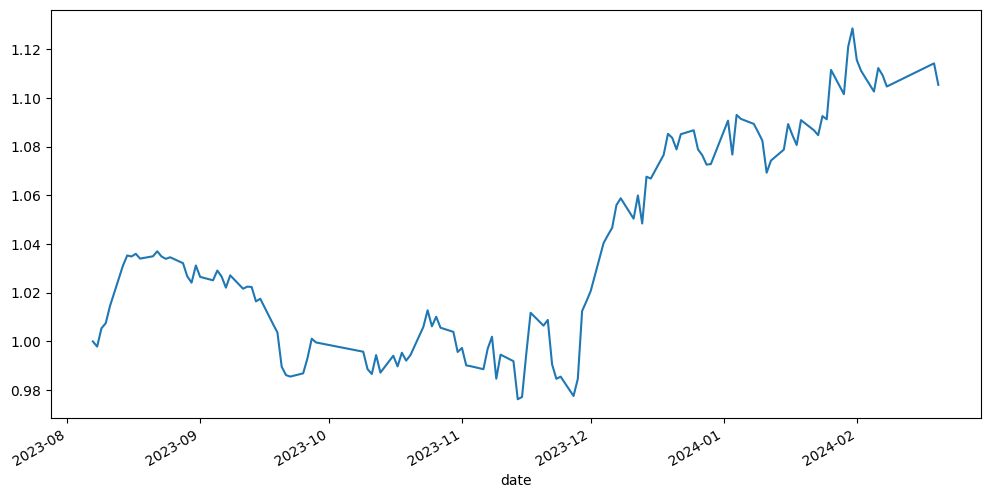

In [38]:
plt.figure(figsize=(12, 6))
df['portfolio_value'].plot()
plt.show()

In [39]:
end = time.time()

In [40]:
runTime = (end - start) // 60   # runTime是多少分钟

In [41]:
print("程序运行时间为：", runTime, "分钟")

程序运行时间为： 281.0 分钟


In [42]:
# 训练结束后，把随机种子数值打印出来
print("\n本次训练使用的随机种子值：")
print(f"np.random.seed({seeds_dict['numpy_seed']})")
print(f"random.seed({seeds_dict['random_seed']})")
print(f"torch.manual_seed({seeds_dict['torch_seed']})")
print(f"torch.cuda.manual_seed({seeds_dict['cuda_seed']})")
print(f"torch.cuda.manual_seed_all({seeds_dict['cuda_all_seed']})")


本次训练使用的随机种子值：
np.random.seed(334244355)
random.seed(1639950351)
torch.manual_seed(1790997128)
torch.cuda.manual_seed(1971071600)
torch.cuda.manual_seed_all(734789405)
